In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

# Preprocessing for recall

In [ ]:
import pandas as pd
from tqdm import tqdm
import os
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')

In [ ]:
current_phase = 2
phases = [i for i in range(current_phase + 1)]

In [ ]:
click_list = []
test_qtime_list = []

for i in tqdm(phases):
    #read train_click 
    df_click_train = pd.read_csv(
        'kdd2020_data/underexpose_train/underexpose_train_click-{}.csv'.format(i),
        header=None)
    df_click_train.columns = ['user_id', 'item_id', 'time']
    df_click_train['phase'] = i
    click_list.append(df_click_train)

    #read test_click 
    df_click_test = pd.read_csv(
        'kdd2020_data/underexpose_test/underexpose_test_click-{}.csv'.format(i),
        header=None)
    df_click_test.columns = ['user_id', 'item_id', 'time']
    df_click_test['phase'] = i

    df_qtime_test = pd.read_csv('kdd2020_data/underexpose_test/underexpose_test_qtime-{}.csv'.format(i),
        header=None)
    df_qtime_test.columns = ['user_id', 'query_time']
    df_qtime_test['item_id'] = -1
    df_qtime_test['phase'] = i
    
    #combine
    click_list.append(df_click_test)
    test_qtime_list.append(df_qtime_test)

100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


In [ ]:
#change list to df
df_click = pd.concat(click_list)
df_click = df_click.sort_values(['user_id', 'time']).reset_index(drop=True)
df_test_qtime = pd.concat(test_qtime_list)
df_test_qtime = df_test_qtime.sort_values(['user_id', 'query_time']).reset_index(drop=True)

In [ ]:
#know the basic of data
print('train samples:{}'.format(len(df_click)))
print('test samples:{}'.format(len(df_test_qtime)))

train samples:795911
test samples:5079


In [ ]:
#del the sample in test who's time is later than qtime 
df_ = df_test_qtime.groupby(['phase'])['user_id'].apply(lambda x: sorted(list(set(x)))).reset_index()
phase_testusers_dict = dict(zip(df_['phase'], df_['user_id']))

click_list = []
train_qtime_list = []

groups = df_click.groupby(['phase', 'user_id'])
for (phase, user_id), g in tqdm(groups):
    if user_id in phase_testusers_dict[phase]:
        qtime = df_test_qtime[(df_test_qtime['user_id'] == user_id) & (
            df_test_qtime['phase'] == phase)]['query_time'].values[0]
        test_click = g[g['time'] < qtime]
        assert test_click.shape[0] == g.shape[0]
        click_list.append(test_click)
#use the last time as qtime
    else:
        train_qtime = g.tail(1)
        train_qtime_list.append(train_qtime)

        train_click = g.head(g.shape[0] - 1)
        click_list.append(train_click)

100%|██████████| 55575/55575 [01:01<00:00, 906.13it/s]


In [ ]:
df_click = pd.concat(click_list, sort=False)
df_train_qtime = pd.concat(train_qtime_list)
df_train_qtime.rename(columns={'time': 'query_time'}, inplace=True)
df_train_qtime = df_train_qtime[['user_id', 'query_time', 'item_id', 'phase']]
print('number of users in train', df_train_qtime['user_id'].nunique())

number of users in train 23307


In [ ]:
#label
df_qtime = pd.concat([df_train_qtime, df_test_qtime], sort=False)

In [ ]:
#save
df_qtime.to_pickle('kdd2020_data/recall/qtime.pkl')
df_click.to_pickle('kdd2020_data/recall/click.pkl')

# Recall_1
**item_cf:**
* 1:
$w_{ij}=\frac{{N(i)}\bigcap{N(j)}}{N(i)}$


* 2:
$w_{ij}=\frac{{N(i)}\bigcap{N(j)}}{(N(i)*N(j))^{0.5}}$


* 3:
$w_{ij}=\frac{\sum_(\frac{1}{\log{(1+N(x))}})}{(N(i)*N(j))^{0.5}}$

N(i): how many people have interaction on item i 

N(j): how many people have interaction on item j

N(x): how many items the people have interaction on, those people who have interaction both on item i and j 

* 4:
we also can import some time and location parameters.

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import warnings
from collections import defaultdict
import math
import pickle
import multitasking
import signal

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
def rec1_item_sim(df, user_col, item_col):

    user_item_ = df.groupby(user_col)[item_col].agg(lambda x: list(x)).reset_index()
    user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))

    user_time_ = df.groupby(user_col)['time'].agg(lambda x: list(x)).reset_index()  
    user_time_dict = dict(zip(user_time_[user_col], user_time_['time']))

    sim_item = {}
    item_cnt = defaultdict(int)
    for user, items in tqdm(user_item_dict.items()):
        for loc1, item in enumerate(items):
            item_cnt[item] += 1
            sim_item.setdefault(item, {})
            for loc2, relate_item in enumerate(items):
                t1 = user_time_dict[user][loc1]
                t2 = user_time_dict[user][loc2]
                #filter the distance bigger than 5 or the time difference bigger than 0.000003
                if abs(loc2 -loc1) > 5 or item == relate_item or abs(t2-t1) > 0.000003:
                    continue
                #filter itself
                if loc2-loc1==0:
                  continue
                sim_item[item].setdefault(relate_item, 0)

                #consider of the position relation
                if loc1 - loc2 > 0:
                    sim_item[item][relate_item] += 0.7 * (0.8**(loc1 - loc2 -
                                  1)) * (1 - (t1 - t2) * 10000) / math.log(
                                      1 + len(items))  
                else:
                    sim_item[item][relate_item] += 1.0 * (0.8**(loc2 - loc1 -
                                  1)) * (1 - (t2 - t1) * 10000) / math.log(
                                      1 + len(items))  

    sim_item_corr = sim_item.copy()
    for i, related_items in tqdm(sim_item.items()):
        for j, cij in related_items.items():
            sim_item_corr[i][j] = cij / math.sqrt(item_cnt[i] * item_cnt[j])

    return sim_item_corr, user_item_dict, item_cnt, user_time_dict

In [ ]:
def rec1(df_qtime, item_sim_list, user_item, item_cnt, user_time_dict):
    data_list = []
    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        rank = {}
        interacted_items = user_item[user_id]
        #reverse
        interacted_items = interacted_items[::-1] 
        for loc, i in enumerate(interacted_items):
            #import time factor
            time_factor = 1-1000 * (query_time - user_time_dict[user_id][len(interacted_items)-loc-1]) 
            #1:500
            for j, wij in sorted(item_sim_list[i].items(),key=lambda d: d[1],reverse=True)[0:500]:
                if j not in interacted_items:
                    rank.setdefault(j, 0)
                    rank[j] += wij * (0.7**loc) * item_cnt[j] * time_factor
        #filter top100
        sim_items = sorted(rank.items(), key=lambda d: d[1],reverse=True)[:100]
        item_ids = [item[0] for item in sim_items]
        item_sim_scores = [item[1] for item in sim_items]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
        #if we hit the item, the label is 1,otherwise the label is 0.
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)
        df_temp = df_temp[['user_id', 'phase', 'query_time', 'item_id', 'sim_score', 'label']]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)

    return df_data

In [ ]:
@multitasking.task
#recall depend on phase
def work(phase, force=False):
    os.makedirs('kdd2020_data/my_model/recall_1', exist_ok=True)

    if force or (
            not os.path.exists(
                'kdd2020_data/my_model/recall_1/sim_{}.pkl'.format(phase))
            or not os.path.exists(
                'kdd2020_data/my_model/recall_1/recall_{}.pkl'.format(phase))):
        
        df_click_phase = df_click[df_click['phase'] == phase]
        item_sim, user_item, item_cnt, user_time_dict = rec1_item_sim(df_click_phase, 'user_id', 'item_id')

        f = open('kdd2020_data/my_model/recall_1/sim_{}.pkl'.format(phase), 'wb')
        pickle.dump(item_sim, f)
        f.close()

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec1(df_qtime_phase, item_sim, user_item, item_cnt,user_time_dict)
        df_data.to_pickle('kdd2020_data/my_model/recall_1/recall_{}.pkl'.format(phase))

        print('phase {} finish'.format(phase))

In [ ]:
force = False
for phase in phases:
    work(phase, force)
    
multitasking.wait_for_tasks()
print('over')

100%|██████████| 18672/18672 [08:19<00:00, 37.38it/s]


phase 2 finish
phase 0 finish
phase 1 finish
over


**ndcg@K**

$ndcg@K=\frac{\sum_1^n{\frac{Gain(r)}{log_2(r+1)}}}{n}$

n:the num we have recall for every user

r:the location of the recall item who's label is 1

Gain(r): the gain when we hit the target, here is 1

In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]
    
    #filter traindata
    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']<= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
item_sim_phase = {}
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
for phase in phases:
    f = open('kdd2020_data/my_model/recall_1/sim_{}.pkl'.format(phase), 'rb')
    item_sim = pickle.load(f)
    f.close()

    df_data = pd.read_pickle('kdd2020_data/my_model/recall_1/recall_{}.pkl'.format(phase))

    item_sim_phase[phase] = item_sim
    df_recall = df_recall.append(df_data)

    score = evaluate_scores(df_data, phase)
    val_score += score

    print('phase', phase, score)

100%|██████████| 18504/18504 [00:19<00:00, 961.85it/s]


phase 0 (0.049471085766303685, 0.11483196769979813, 0.02038499422582166, 0.06592146746918888)


100%|██████████| 18670/18670 [00:19<00:00, 956.38it/s]


phase 1 (0.04991123719165572, 0.11672371061017349, 0.018408447503913128, 0.0608195542774982)


100%|██████████| 18396/18396 [00:19<00:00, 953.79it/s]

phase 2 (0.05024071422638227, 0.11856595642805841, 0.018270022854726724, 0.06242603550295858)


In [ ]:
#save the similarity 
f = open('kdd2020_data/my_model/sim1.pkl', 'wb')
pickle.dump(item_sim_phase, f)
f.close()

In [ ]:
val_score
#save recall1
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_1.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.9839419315,87837,0.7427316859,0.0
1,1,0.0,0.9839419315,92349,0.5806058044,0.0
2,1,0.0,0.9839419315,91290,0.5208125481,0.0
3,1,0.0,0.9839419315,38168,0.4589800761,0.0
4,1,0.0,0.9839419315,13663,0.4499775748,0.0


# Recall_2

**item_cf**

$w_{ij}=\sum_{\frac{1}{log(len(items)+1)*log(len(users)+1)}}$

len(items):how many items the people have interaction on, those people who have interaction both on item i and j 

len(users):how many people have interaction on item i 


**reference:**

Zhou T, Ren J, Medo M, et al. Bipartite network projection and personal recommendation[J]. Physical review E, 2007, 76(4): 046115.

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import warnings
from collections import defaultdict
import math
import pickle
import multitasking
import signal

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
def rec2_item_sim(df, user_col, item_col):
    user_item_ = df.groupby(user_col)[item_col].agg(list).reset_index()
    user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))

    item_user_ = df.groupby(item_col)[user_col].agg(list).reset_index()
    item_user_dict = dict(zip(item_user_[item_col], item_user_[user_col]))

    user_time_ = df.groupby(user_col)['time'].agg(lambda x: list(x)).reset_index()
    user_time_dict = dict(zip(user_time_[user_col], user_time_['time']))

    sim_item = {}
    for item, users in tqdm(item_user_dict.items()):
        sim_item.setdefault(item, {})

        for u in users:
            items = user_item_dict[u]

            for relate_item in items:
                if item==relate_item:
                  continue
                loc1 = user_item_dict[u].index(item)
                loc2 = user_item_dict[u].index(relate_item)

                t1 = user_time_dict[u][loc1]
                t2 = user_time_dict[u][loc2]

                sim_item[item].setdefault(relate_item, 0)
                sim_item[item][relate_item] += 1 / (math.log(len(users)+1) * math.log(len(items)+1))

    return sim_item, user_item_dict

In [ ]:
def rec2(df_qtime, item_sim_list, user_item):
    data_list = []
    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        rank = {}
        interacted_items = user_item[user_id]
        interacted_items = interacted_items[::-1]
        for loc, i in enumerate(interacted_items):
            for j, wij in sorted(item_sim_list[i].items(),
                                 key=lambda d: d[1],
                                 reverse=True)[0:500]:
                if j not in interacted_items:
                    rank.setdefault(j, 0)
                    rank[j] += wij * (0.7**loc)

        sim_items = sorted(rank.items(), key=lambda d: d[1],
                           reverse=True)[:100]
        item_ids = [item[0] for item in sim_items]
        item_sim_scores = [item[1] for item in sim_items]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)
        df_temp = df_temp[[
            'user_id', 'phase', 'query_time', 'item_id', 'sim_score', 'label'
        ]]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)
    return df_data

In [ ]:
@multitasking.task
def work(phase, force=False):
    os.makedirs('kdd2020_data/my_model/recall_2', exist_ok=True)

    if force or (
            not os.path.exists('kdd2020_data/my_model/recall_2/sim_{}.pkl'.format(phase))
            or not os.path.exists('kdd2020_data/my_model/recall_2/recall_{}.pkl'.format(phase))):
      
        df_click_phase = df_click[df_click['phase'] == phase]
        sim_item, user_item_dict = rec2_item_sim(df_click_phase, 'user_id','item_id')

        f = open('kdd2020_data/my_model/recall_2/sim_{}.pkl'.format(phase), 'wb')
        pickle.dump(sim_item, f)
        f.close()

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec2(df_qtime_phase, sim_item, user_item_dict)
        df_data.to_pickle('kdd2020_data/my_model/recall_2/recall_{}.pkl'.format(phase))

        print('phase {} finish'.format(phase))

In [ ]:
force = False
for phase in phases:
    work(phase, force)

multitasking.wait_for_tasks()
print('over')

100%|██████████| 18398/18398 [10:20<00:00, 29.65it/s]


phase 0 finish
phase 1 finish
phase 2 finish
over


In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]

    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']<= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
item_sim_phase = {}
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
for phase in phases:
    f = open('kdd2020_data/my_model/recall_2/sim_{}.pkl'.format(phase), 'rb')
    item_sim = pickle.load(f)
    f.close()

    df_data = pd.read_pickle('kdd2020_data/my_model/recall_2/recall_{}.pkl'.format(phase))

    item_sim_phase[phase] = item_sim
    df_recall = df_recall.append(df_data)

    score = evaluate_scores(df_data, phase)
    val_score += score

    print('phase', phase, score)

100%|██████████| 18505/18505 [00:19<00:00, 948.77it/s]


phase 0 (0.049057716332143474, 0.10996318726992044, 0.0229912553375824, 0.0649183147033534)


100%|██████████| 18672/18672 [00:19<00:00, 946.03it/s]


phase 1 (0.05058691751623233, 0.11141272276643456, 0.023137793927580964, 0.06182602444284687)


100%|██████████| 18398/18398 [00:19<00:00, 957.64it/s]


phase 2 (0.05110817778025587, 0.11503471390950443, 0.022897075829062, 0.06420118343195266)


In [ ]:
f = open('kdd2020_data/my_model/sim2.pkl', 'wb')
pickle.dump(item_sim_phase, f)
f.close()
val_score

array([0.15075281, 0.33641062, 0.06902613, 0.19094552])

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_2.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.9839419315,87837,0.3453144185,0.0
2,1,0.0,0.9839419315,19228,0.3453144185,0.0
3,1,0.0,0.9839419315,109854,0.3453144185,0.0
4,1,0.0,0.9839419315,55738,0.3453144185,0.0
1,1,0.0,0.9839419315,91290,0.3453144185,0.0


# Recall_3

* get item txt  embedding
* calculate distance by annoy

[know more about annoy](https://github.com/spotify/annoy)

In [ ]:
!pip install annoy

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from annoy import AnnoyIndex
import os
import warnings
import multitasking
import signal

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
df_item = pd.read_csv('kdd2020_data/underexpose_train/underexpose_item_feat.csv',header=None)
df_item.columns = ['item_id'] + ['txt_vec' + str(i) for i in range(128)] + ['img_vec' + str(i) for i in range(128)]
df_item['txt_vec0'] = df_item['txt_vec0'].apply(lambda x: float(x[1:]))
df_item['txt_vec127'] = df_item['txt_vec127'].apply(lambda x: float(x[:-1]))
df_item['img_vec0'] = df_item['img_vec0'].apply(lambda x: float(x[1:]))
df_item['img_vec127'] = df_item['img_vec127'].apply(lambda x: float(x[:-1]))
df_item.drop_duplicates(['item_id'], inplace=True)
df_item.head()

,item_id,txt_vec0,txt_vec1,txt_vec2,txt_vec3,txt_vec4,txt_vec5,txt_vec6,txt_vec7,txt_vec8,txt_vec9,txt_vec10,txt_vec11,txt_vec12,txt_vec13,txt_vec14,txt_vec15,txt_vec16,txt_vec17,txt_vec18,txt_vec19,txt_vec20,txt_vec21,txt_vec22,txt_vec23,txt_vec24,txt_vec25,txt_vec26,txt_vec27,txt_vec28,txt_vec29,txt_vec30,txt_vec31,txt_vec32,txt_vec33,txt_vec34,txt_vec35,txt_vec36,txt_vec37,txt_vec38,txt_vec39,txt_vec40,txt_vec41,txt_vec42,txt_vec43,txt_vec44,txt_vec45,txt_vec46,txt_vec47,txt_vec48,txt_vec49,txt_vec50,txt_vec51,txt_vec52,txt_vec53,txt_vec54,txt_vec55,txt_vec56,txt_vec57,txt_vec58,txt_vec59,txt_vec60,txt_vec61,txt_vec62,txt_vec63,txt_vec64,txt_vec65,txt_vec66,txt_vec67,txt_vec68,txt_vec69,txt_vec70,txt_vec71,txt_vec72,txt_vec73,txt_vec74,txt_vec75,txt_vec76,txt_vec77,txt_vec78,txt_vec79,txt_vec80,txt_vec81,txt_vec82,txt_vec83,txt_vec84,txt_vec85,txt_vec86,txt_vec87,txt_vec88,txt_vec89,txt_vec90,txt_vec91,txt_vec92,txt_vec93,txt_vec94,txt_vec95,txt_vec96,txt_vec97,txt_vec98,txt_vec99,txt_vec100,txt_vec101,txt_vec102,txt_vec103,txt_vec104,txt_vec105,txt_vec106,txt_vec107,txt_vec108,txt_vec109,txt_vec110,txt_vec111,txt_vec112,txt_vec113,txt_vec114,txt_vec115,txt_vec116,txt_vec117,txt_vec118,txt_vec119,txt_vec120,txt_vec121,txt_vec122,txt_vec123,txt_vec124,txt_vec125,txt_vec126,txt_vec127,img_vec0,img_vec1,img_vec2,img_vec3,img_vec4,img_vec5,img_vec6,img_vec7,img_vec8,img_vec9,img_vec10,img_vec11,img_vec12,img_vec13,img_vec14,img_vec15,img_vec16,img_vec17,img_vec18,img_vec19,img_vec20,img_vec21,img_vec22,img_vec23,img_vec24,img_vec25,img_vec26,img_vec27,img_vec28,img_vec29,img_vec30,img_vec31,img_vec32,img_vec33,img_vec34,img_vec35,img_vec36,img_vec37,img_vec38,img_vec39,img_vec40,img_vec41,img_vec42,img_vec43,img_vec44,img_vec45,img_vec46,img_vec47,img_vec48,img_vec49,img_vec50,img_vec51,img_vec52,img_vec53,img_vec54,img_vec55,img_vec56,img_vec57,img_vec58,img_vec59,img_vec60,img_vec61,img_vec62,img_vec63,img_vec64,img_vec65,img_vec66,img_vec67,img_vec68,img_vec69,img_vec70,img_vec71,img_vec72,img_vec73,img_vec74,img_vec75,img_vec76,img_vec77,img_vec78,img_vec79,img_vec80,img_vec81,img_vec82,img_vec83,img_vec84,img_vec85,img_vec86,img_vec87,img_vec88,img_vec89,img_vec90,img_vec91,img_vec92,img_vec93,img_vec94,img_vec95,img_vec96,img_vec97,img_vec98,img_vec99,img_vec100,img_vec101,img_vec102,img_vec103,img_vec104,img_vec105,img_vec106,img_vec107,img_vec108,img_vec109,img_vec110,img_vec111,img_vec112,img_vec113,img_vec114,img_vec115,img_vec116,img_vec117,img_vec118,img_vec119,img_vec120,img_vec121,img_vec122,img_vec123,img_vec124,img_vec125,img_vec126,img_vec127
0,42844,4.5149450302,-2.3837196827,0.5004140139,0.4070682824,-1.9952288866,0.1090780124,-0.6917753220,2.2274599075,-6.4379744530,-0.8248971701,-0.1387242377,-0.3793291748,0.6276600957,0.4183767140,4.4412183762,0.2998193502,0.5785568357,-4.6992893219,-0.3947401643,-2.3916513920,0.3705316782,-1.3554661274,-1.0741775036,-2.3216402531,-0.3324561715,0.1238859445,-2.4391555786,-0.3455986977,-3.3043470383,1.4852843285,0.9098017812,-1.6430019140,5.0370340347,2.7801148891,4.7764964104,2.2552747726,3.7697074413,-3.6616835594,-0.6494054794,4.1996359825,-0.6348056197,2.4303400517,-2.8740186691,-0.7861775160,-0.5049162507,-6.0077886581,1.4984948635,1.5306128263,2.3796546459,-0.0231464375,-0.7036052942,2.1469361782,3.9448320866,-3.0985984802,2.5134534836,-5.3958601952,0.7621323466,2.8018035889,0.8779643178,-0.5859798193,1.9625556469,-5.1712174416,1.1816873550,0.5419528484,0.4858333170,4.2125682831,3.4581983089,1.4029390812,-0.5462926030,2.1821005344,-0.0962546766,1.7366081476,0.6851462722,-1.6132848263,-0.9128761888,-0.5323970318,1.7248421907,2.2641146183,-2.2597558498,4.5065088272,-0.3460883200,0.9281976819,-2.0782611370,-0.1955756247,4.8475780487,-2.9586863518,1.0060796738,2.0822322369,-2.2596824169,-2.0333144665,0.2182324231,3.9753122330,2.0034470558,-0.2406283617,-2.4685480595,1.6660641432,-2.0819606781,-2.4968724251,-1.9016369581,0.2714739740,-2.2981684208,-1.7873090506,1.618066906

In [ ]:
#combine
df_txt_vec = df_item[['item_id'] + ['txt_vec' + str(i) for i in range(128)]]
df_txt_vec['item_txt_vec'] = df_txt_vec.apply(lambda x: np.array(x.values[1:].tolist()), axis=1)
items = df_txt_vec['item_id'].values.tolist()
txt_vecs = df_txt_vec['item_txt_vec'].values.tolist()
df_txt_vec[['item_id','item_txt_vec']].to_pickle('kdd2020_data/my_model/item_txt_vec.pkl')

item_vec_map = dict(zip(items, txt_vecs))

In [ ]:
# setup index for item_txt 
index_to_item_dict = {}
item_to_index_dict = {}

item_index = AnnoyIndex(128, 'angular')
item_index.set_seed(2020)

for i, row in tqdm(df_item.iterrows()):
    emb = row[-128 - 128:-128].values

    item = row[0]
    index_to_item_dict[i] = item
    item_to_index_dict[item] = i

    item_index.add_item(i, emb)

item_index.build(100)

108916it [00:22, 4802.68it/s]


True

In [ ]:
def rec3(df_qtime, user_embs, item_index, index_to_item_dict):
    data_list = []
    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        user_emb = user_embs[user_id]
        ids, distances = item_index.get_nns_by_vector(user_emb,100,include_distances=True)
        item_ids = [index_to_item_dict[id] for id in ids]
        # the smaller distance, the higher score
        item_sim_scores = [2 - distance for distance in distances]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)

        df_temp = df_temp[['user_id', 'phase', 'query_time', 'item_id', 'sim_score', 'label']]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)
    return df_data

In [ ]:
@multitasking.task
def work(phase, force=False):
    os.makedirs('kdd2020_data/my_model/recall_3', exist_ok=True)

    if force or (not os.path.exists('kdd2020_data/my_model/recall_3/user_txt_vec_{}.pkl'.format(phase))
                 or not os.path.exists('kdd2020_data/my_model/recall_3/recall_{}.pkl'.format(phase))):
      
        df_click_phase = df_click[df_click['phase'] == phase]

        tmp = df_click_phase.groupby('user_id', as_index=False)['item_id'].agg({'list': list})
        sentences = tmp['list'].values.tolist()
        del tmp['list']

        emb_matrix = []
        for seq in sentences:
            seq = seq[::-1]

            vec = []
            for pos, w in enumerate(seq):
                if w in item_vec_map.keys():
                    vec.append(np.asarray(item_vec_map[w]) * (0.7**pos))
            if len(vec) > 0:
            #we get the seq vec by average all the item's vec in the seq
                emb_matrix.append(np.mean(vec, axis=0))
            else:
                emb_matrix.append([0] * 128)

        df_user_txt_vec = tmp
        df_user_txt_vec['user_txt_vec'] = emb_matrix
        df_user_txt_vec['phase'] = phase
        df_user_txt_vec.to_pickle('kdd2020_data/my_model/recall_3/user_txt_vec_{}.pkl'.format(phase))

        users = tmp['user_id'].values.tolist()
        user_embs = dict(zip(users, emb_matrix))

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec3(df_qtime_phase, user_embs, item_index,index_to_item_dict)
        df_data.to_pickle('kdd2020_data/my_model/recall_3/recall_{}.pkl'.format(phase))

In [ ]:
force = False

for phase in phases:
    work(phase, force)

multitasking.wait_for_tasks()
print('over')

100%|██████████| 18672/18672 [08:29<00:00, 36.63it/s]


over


In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]

    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']
                                        <= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
df_user_txt_vec_phase = pd.DataFrame()
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
df_user_txt_vec_phase = pd.DataFrame()
for phase in phases:
    df_user_txt_vec = pd.read_pickle('kdd2020_data/my_model/recall_3/user_txt_vec_{}.pkl'.format(phase))
    df_data = pd.read_pickle('kdd2020_data/my_model/recall_3/recall_{}.pkl'.format(phase))

    df_user_txt_vec_phase = df_user_txt_vec_phase.append(df_user_txt_vec)
    df_recall = df_recall.append(df_data)

    score = evaluate_scores(df_data, phase)
    val_score += score

    print('phase', phase, score)

100%|██████████| 18505/18505 [00:20<00:00, 920.10it/s]


phase 0 (0.014335585410384724, 0.04666904168151051, 0.017106936269604182, 0.055030094582975066)


100%|██████████| 18672/18672 [00:19<00:00, 960.31it/s]


phase 1 (0.014106905161240297, 0.046795704000944176, 0.0170518460540908, 0.056074766355140186)


100%|██████████| 18398/18398 [00:19<00:00, 934.81it/s]

phase 2 (0.013887293792433884, 0.04626526214986833, 0.016732289354645706, 0.05547337278106509)


In [ ]:
df_user_txt_vec_phase.to_pickle('kdd2020_data/my_model/user_txt_vec.pkl')
val_score

array([0.04232978, 0.13973001, 0.05089107, 0.16657823])

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_3.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.9839419315,17887,1.8132899106,0.0
1,1,0.0,0.9839419315,31443,1.7760233581,0.0
2,1,0.0,0.9839419315,35217,1.7182781398,0.0
3,1,0.0,0.9839419315,58507,1.6969851553,0.0
4,1,0.0,0.9839419315,101535,1.6884627044,0.0


# Recall_4

* get item img embedding
* calculate distance by Annoy

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from annoy import AnnoyIndex
import os
import warnings
import multitasking
import signal

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
df_item = pd.read_csv('kdd2020_data/underexpose_train/underexpose_item_feat.csv',header=None)
df_item.columns = ['item_id'] + ['txt_vec' + str(i) for i in range(128)] + ['img_vec' + str(i) for i in range(128)]
df_item['txt_vec0'] = df_item['txt_vec0'].apply(lambda x: float(x[1:]))
df_item['txt_vec127'] = df_item['txt_vec127'].apply(lambda x: float(x[:-1]))
df_item['img_vec0'] = df_item['img_vec0'].apply(lambda x: float(x[1:]))
df_item['img_vec127'] = df_item['img_vec127'].apply(lambda x: float(x[:-1]))
df_item.drop_duplicates(['item_id'], inplace=True)
df_item.head()

,item_id,txt_vec0,txt_vec1,txt_vec2,txt_vec3,txt_vec4,txt_vec5,txt_vec6,txt_vec7,txt_vec8,txt_vec9,txt_vec10,txt_vec11,txt_vec12,txt_vec13,txt_vec14,txt_vec15,txt_vec16,txt_vec17,txt_vec18,txt_vec19,txt_vec20,txt_vec21,txt_vec22,txt_vec23,txt_vec24,txt_vec25,txt_vec26,txt_vec27,txt_vec28,txt_vec29,txt_vec30,txt_vec31,txt_vec32,txt_vec33,txt_vec34,txt_vec35,txt_vec36,txt_vec37,txt_vec38,txt_vec39,txt_vec40,txt_vec41,txt_vec42,txt_vec43,txt_vec44,txt_vec45,txt_vec46,txt_vec47,txt_vec48,txt_vec49,txt_vec50,txt_vec51,txt_vec52,txt_vec53,txt_vec54,txt_vec55,txt_vec56,txt_vec57,txt_vec58,txt_vec59,txt_vec60,txt_vec61,txt_vec62,txt_vec63,txt_vec64,txt_vec65,txt_vec66,txt_vec67,txt_vec68,txt_vec69,txt_vec70,txt_vec71,txt_vec72,txt_vec73,txt_vec74,txt_vec75,txt_vec76,txt_vec77,txt_vec78,txt_vec79,txt_vec80,txt_vec81,txt_vec82,txt_vec83,txt_vec84,txt_vec85,txt_vec86,txt_vec87,txt_vec88,txt_vec89,txt_vec90,txt_vec91,txt_vec92,txt_vec93,txt_vec94,txt_vec95,txt_vec96,txt_vec97,txt_vec98,txt_vec99,txt_vec100,txt_vec101,txt_vec102,txt_vec103,txt_vec104,txt_vec105,txt_vec106,txt_vec107,txt_vec108,txt_vec109,txt_vec110,txt_vec111,txt_vec112,txt_vec113,txt_vec114,txt_vec115,txt_vec116,txt_vec117,txt_vec118,txt_vec119,txt_vec120,txt_vec121,txt_vec122,txt_vec123,txt_vec124,txt_vec125,txt_vec126,txt_vec127,img_vec0,img_vec1,img_vec2,img_vec3,img_vec4,img_vec5,img_vec6,img_vec7,img_vec8,img_vec9,img_vec10,img_vec11,img_vec12,img_vec13,img_vec14,img_vec15,img_vec16,img_vec17,img_vec18,img_vec19,img_vec20,img_vec21,img_vec22,img_vec23,img_vec24,img_vec25,img_vec26,img_vec27,img_vec28,img_vec29,img_vec30,img_vec31,img_vec32,img_vec33,img_vec34,img_vec35,img_vec36,img_vec37,img_vec38,img_vec39,img_vec40,img_vec41,img_vec42,img_vec43,img_vec44,img_vec45,img_vec46,img_vec47,img_vec48,img_vec49,img_vec50,img_vec51,img_vec52,img_vec53,img_vec54,img_vec55,img_vec56,img_vec57,img_vec58,img_vec59,img_vec60,img_vec61,img_vec62,img_vec63,img_vec64,img_vec65,img_vec66,img_vec67,img_vec68,img_vec69,img_vec70,img_vec71,img_vec72,img_vec73,img_vec74,img_vec75,img_vec76,img_vec77,img_vec78,img_vec79,img_vec80,img_vec81,img_vec82,img_vec83,img_vec84,img_vec85,img_vec86,img_vec87,img_vec88,img_vec89,img_vec90,img_vec91,img_vec92,img_vec93,img_vec94,img_vec95,img_vec96,img_vec97,img_vec98,img_vec99,img_vec100,img_vec101,img_vec102,img_vec103,img_vec104,img_vec105,img_vec106,img_vec107,img_vec108,img_vec109,img_vec110,img_vec111,img_vec112,img_vec113,img_vec114,img_vec115,img_vec116,img_vec117,img_vec118,img_vec119,img_vec120,img_vec121,img_vec122,img_vec123,img_vec124,img_vec125,img_vec126,img_vec127
0,42844,4.5149450302,-2.3837196827,0.5004140139,0.4070682824,-1.9952288866,0.1090780124,-0.6917753220,2.2274599075,-6.4379744530,-0.8248971701,-0.1387242377,-0.3793291748,0.6276600957,0.4183767140,4.4412183762,0.2998193502,0.5785568357,-4.6992893219,-0.3947401643,-2.3916513920,0.3705316782,-1.3554661274,-1.0741775036,-2.3216402531,-0.3324561715,0.1238859445,-2.4391555786,-0.3455986977,-3.3043470383,1.4852843285,0.9098017812,-1.6430019140,5.0370340347,2.7801148891,4.7764964104,2.2552747726,3.7697074413,-3.6616835594,-0.6494054794,4.1996359825,-0.6348056197,2.4303400517,-2.8740186691,-0.7861775160,-0.5049162507,-6.0077886581,1.4984948635,1.5306128263,2.3796546459,-0.0231464375,-0.7036052942,2.1469361782,3.9448320866,-3.0985984802,2.5134534836,-5.3958601952,0.7621323466,2.8018035889,0.8779643178,-0.5859798193,1.9625556469,-5.1712174416,1.1816873550,0.5419528484,0.4858333170,4.2125682831,3.4581983089,1.4029390812,-0.5462926030,2.1821005344,-0.0962546766,1.7366081476,0.6851462722,-1.6132848263,-0.9128761888,-0.5323970318,1.7248421907,2.2641146183,-2.2597558498,4.5065088272,-0.3460883200,0.9281976819,-2.0782611370,-0.1955756247,4.8475780487,-2.9586863518,1.0060796738,2.0822322369,-2.2596824169,-2.0333144665,0.2182324231,3.9753122330,2.0034470558,-0.2406283617,-2.4685480595,1.6660641432,-2.0819606781,-2.4968724251,-1.9016369581,0.2714739740,-2.2981684208,-1.7873090506,1.618066906

In [ ]:
df_img_vec = df_item[['item_id'] + ['img_vec' + str(i) for i in range(128)]]
df_img_vec['item_img_vec'] = df_img_vec.apply(lambda x: np.array(x.values[1:].tolist()), axis=1)
items = df_img_vec['item_id'].values.tolist()
img_vecs = df_img_vec['item_img_vec'].values.tolist()
df_img_vec[['item_id','item_img_vec']].to_pickle('kdd2020_data/my_model/item_img_vec.pkl')

item_vec_map = dict(zip(items, img_vecs))

In [ ]:
#setup index for item img
index_to_item_dict = {}
item_to_index_dict = {}

item_index = AnnoyIndex(128, 'angular')
item_index.set_seed(2020)

for i, row in tqdm(df_item.iterrows()):
    emb = row[-128:].values

    item = row[0]
    index_to_item_dict[i] = item
    item_to_index_dict[item] = i

    item_index.add_item(i, emb)

item_index.build(100)

108916it [00:22, 4777.05it/s]


True

In [ ]:
def rec4(df_qtime, user_embs, item_index, index_to_item_dict):
    data_list = []
    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        user_emb = user_embs[user_id]
        ids, distances = item_index.get_nns_by_vector(user_emb,100,include_distances=True)

        item_ids = [index_to_item_dict[id] for id in ids]
        
        item_sim_scores = [2 - distance for distance in distances]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)

        df_temp = df_temp[[
            'user_id', 'phase', 'query_time', 'item_id', 'sim_score', 'label'
        ]]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)
    return df_data

In [ ]:
@multitasking.task
def work(phase, force=False):
    os.makedirs('kdd2020_data/my_model/recall_4', exist_ok=True)

    if force or (not os.path.exists('kdd2020_data/my_model/recall_4/user_img_vec{}.pkl'.format(phase))
                 or not os.path.exists('kdd2020_data/my_model/recall_4/recall_{}.pkl'.format(phase))):
        # 获取当前阶段的click
        df_click_phase = df_click[df_click['phase'] == phase]

        # 生成用户embedding
        tmp = df_click_phase.groupby('user_id', as_index=False)['item_id'].agg(
            {'list': list})
        sentences = tmp['list'].values.tolist()
        del tmp['list']

        emb_matrix = []
        for seq in sentences:
            seq = seq[::-1]

            vec = []
            for pos, w in enumerate(seq):
                if w in item_vec_map.keys():
                    vec.append(np.asarray(item_vec_map[w]) * (0.7**pos))
            if len(vec) > 0:
                emb_matrix.append(np.mean(vec, axis=0))
            else:
                emb_matrix.append([0] * 128)

        df_user_img_vec = tmp
        df_user_img_vec['user_img_vec'] = emb_matrix
        # df_user_img_vec.to_pickle('kdd2020_data/my_model/user_img_vec.pkl')
        df_user_img_vec['phase'] = phase
        df_user_img_vec.to_pickle('kdd2020_data/my_model/recall_4/user_img_vec{}.pkl'.format(phase))

        users = tmp['user_id'].values.tolist()
        user_embs = dict(zip(users, emb_matrix))

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec4(df_qtime_phase, user_embs, item_index,index_to_item_dict)

        df_data.to_pickle('kdd2020_data/my_model/recall_4/recall_{}.pkl'.format(phase))

In [ ]:
force = False
for phase in phases:
    work(phase, force)

multitasking.wait_for_tasks()
print('over')

100%|██████████| 18672/18672 [08:03<00:00, 38.66it/s]


over


In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]

    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']
                                        <= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
df_user_img_vec_phase = pd.DataFrame()
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
df_user_txt_vec_phase = pd.DataFrame()
for phase in phases:
    df_user_img_vec = pd.read_pickle('kdd2020_data/my_model/recall_4/user_img_vec{}.pkl'.format(phase))
    df_data = pd.read_pickle('kdd2020_data/my_model/recall_4/recall_{}.pkl'.format(phase))

    df_user_img_vec_phase = df_user_img_vec_phase.append(df_user_img_vec)
    df_recall = df_recall.append(df_data)

    score = evaluate_scores(df_data, phase)
    val_score += score

    print('phase', phase, score)

100%|██████████| 18505/18505 [00:18<00:00, 989.55it/s]


phase 0 (0.0064046248809043185, 0.020484503028143926, 0.007743461517184497, 0.02421897391802809)


100%|██████████| 18672/18672 [00:19<00:00, 980.96it/s]


phase 1 (0.0068464595884933175, 0.021893072111412722, 0.008489119674941013, 0.025880661394680086)


100%|██████████| 18398/18398 [00:19<00:00, 956.49it/s] 

phase 2 (0.0069302797515830026, 0.023042853722767535, 0.007733284420870578, 0.02529585798816568)


In [ ]:
df_user_img_vec_phase.to_pickle('kdd2020_data/my_model/user_img_vec.pkl')
val_score

array([0.02018136, 0.06542043, 0.02396587, 0.07539549])

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_4.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.9839419315,17887,1.5567105114,0.0
1,1,0.0,0.9839419315,17559,1.5547946692,0.0
2,1,0.0,0.9839419315,37316,1.5266568065,0.0
3,1,0.0,0.9839419315,31443,1.5244504213,0.0
4,1,0.0,0.9839419315,35217,1.5183159113,0.0


# Recall_5

**item cf**

$w_{ij}=\frac{\sum_(a*b*c*d)}{(N(i)*N(j))^{0.5}}$

* a: a penalty function for rank distance
* b: a penalty function for time
* c: a penalty function for item txt
* d: a penalty function for item img

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from annoy import AnnoyIndex
import os
import warnings
from collections import defaultdict
import math
import pickle
import gc
import multitasking
import signal

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
def euc(v, w):
    if np.max(v) == 0 and np.min(v) == 0 and np.max(w) == 0 and np.min(w) == 0:
        return 10
    return np.sqrt(np.sum(np.square(v - w)))

In [ ]:
def item2item(user_item_set_dict, item_user_set_dict, rank_dict, time_dict,
              txt_vec_dict, img_vec_dict, sim_topN):
    item2item_sim_dict = {}
    for user in tqdm(user_item_set_dict.keys()):
        for item1 in user_item_set_dict[user]:
            if item1 not in item2item_sim_dict.keys():
                item2item_sim_dict[item1] = {}
            for item2 in user_item_set_dict[user]:
                if item1 == item2:
                    continue
                if item2 not in item2item_sim_dict[item1].keys():
                    item2item_sim_dict[item1][item2] = 0
                heat_factor = 1 / (np.log2(1 + len(user_item_set_dict[user])) + 
                                np.sqrt(abs(rank_dict[user][item1] - rank_dict[user][item2])))
                time_factor = 1 / \
                    np.sqrt(1 + 20000 * abs(time_dict[user][item1] - time_dict[user][item2]))
                txt_euc_factor = 1 / \
                    np.sqrt(1 + euc(txt_vec_dict[item1], txt_vec_dict[item2]))
                img_euc_factor = 1 / \
                    np.sqrt(1 + euc(img_vec_dict[item1], img_vec_dict[item2]) / 10)
                score = heat_factor * time_factor * txt_euc_factor * img_euc_factor
                item2item_sim_dict[item1][item2] += score / np.sqrt(
                    len(item_user_set_dict[item1]) *
                    len(item_user_set_dict[item2]))
    
    new_dic={}
    items = item2item_sim_dict.keys()
    for item in tqdm(items):
      if len(item2item_sim_dict[item]) == 0:
          # del item2item_sim_dict[item]
          continue
      elif len(item2item_sim_dict[item]) > sim_topN:
        new=dict(sorted(item2item_sim_dict[item].items(),key=lambda x: x[1],
                       reverse=True)[:sim_topN])
        new_dic[item] =new
      else:
        new=dict(sorted(item2item_sim_dict[item].items(),
                       key=lambda x: x[1],
                       reverse=True))
        new_dic[item] =new

    # return item2item_sim_dict
    return new_dic

In [ ]:
def rec5(df_qtime, item2item_sim_dict, user_item_set_dict, rank_dict,
           time_dict, txt_vec_dict, recall_topN):
    data_list = []

    qtime_dict = dict(zip(df_qtime['user_id'], df_qtime['query_time']))

    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        rank = {}
        for item in user_item_set_dict[user_id]:
            if item not in item2item_sim_dict.keys():
              continue
            for i in item2item_sim_dict[item].keys():
                if i in user_item_set_dict[user_id]:
                    continue
                if i not in rank.keys():
                    rank[i] = 0
                rank_factor = 1 / np.sqrt(rank_dict[user_id][item])
                time_factor = 1 - 1000 * \
                    (qtime_dict[user_id] - time_dict[user_id][item])
                txt_euc_factor = 1 / \
                    (1 + euc(txt_vec_dict[i], txt_vec_dict[item]) / 100)
                rank[i] += item2item_sim_dict[item][i] * \
                    rank_factor * time_factor * txt_euc_factor

        sim_items = sorted(rank.items(), key=lambda d: d[1],
                           reverse=True)[:recall_topN]
        item_ids = [item[0] for item in sim_items]
        item_sim_scores = [item[1] for item in sim_items]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)
        df_temp = df_temp[[
            'user_id', 'phase', 'query_time', 'item_id', 'sim_score', 'label'
        ]]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)
    return df_data

In [ ]:
txt_vec_cols = ['txt_vec_{}'.format(i) for i in range(128)]
img_vec_cols = ['img_vec_{}'.format(i) for i in range(128)]
vec_df = pd.read_csv('kdd2020_data/underexpose_train/underexpose_item_feat.csv',
                     names=['item_id'] + txt_vec_cols + img_vec_cols)
vec_df['txt_vec_0'] = vec_df['txt_vec_0'].apply(lambda x: x.strip()[1:])
vec_df['txt_vec_127'] = vec_df['txt_vec_127'].apply(lambda x: x.strip()[:-1])
vec_df['img_vec_0'] = vec_df['img_vec_0'].apply(lambda x: x.strip()[1:])
vec_df['img_vec_127'] = vec_df['img_vec_127'].apply(lambda x: x.strip()[:-1])
vec_df[txt_vec_cols + img_vec_cols] = vec_df[txt_vec_cols +img_vec_cols].astype('float')

In [ ]:
@multitasking.task
def work(phase, force=False):
    os.makedirs('kdd2020_data/my_model/recall_5', exist_ok=True)

    if force or (not os.path.exists('kdd2020_data/my_model/recall_5/sim_{}.pkl'.format(phase))
                 or not os.path.exists('kdd2020_data/my_model/recall_5/recall_{}.pkl'.format(phase))):
        
        df_click_phase = df_click[df_click['phase'] == phase]

        df_click_phase = df_click_phase.merge(vec_df, on='item_id', how='left')
        for f in tqdm(txt_vec_cols + img_vec_cols):
            df_click_phase[f] = df_click_phase[f].fillna(0)

        txt_vec_dict = dict(
            zip(df_click_phase['item_id'],
                df_click_phase[txt_vec_cols].values))
        img_vec_dict = dict(
            zip(df_click_phase['item_id'],
                df_click_phase[img_vec_cols].values))

        df_click_phase['rank'] = df_click_phase.groupby('user_id')['time'].rank(method='first', ascending=False)
        rank_df = df_click_phase.groupby('user_id')['item_id', 'rank'].apply(
            lambda x: dict(zip(x['item_id'], x['rank']))).reset_index()
        rank_dict = dict(zip(rank_df['user_id'], rank_df[0]))

        time_df = df_click_phase.groupby('user_id')['item_id', 'time'].apply(
            lambda x: dict(zip(x['item_id'], x['time']))).reset_index()
        time_dict = dict(zip(time_df['user_id'], time_df[0]))

        item_user_set_df = df_click_phase.groupby(
            'item_id', as_index=False)['user_id'].agg({'item_user_set': set})
        item_user_set_dict = dict(
            zip(item_user_set_df['item_id'],
                item_user_set_df['item_user_set']))

        user_item_set_df = df_click_phase.groupby(
            'user_id', as_index=False)['item_id'].agg({'user_item_set': set})
        user_item_set_dict = dict(
            zip(user_item_set_df['user_id'],
                user_item_set_df['user_item_set']))

        del rank_df, time_df, item_user_set_df, user_item_set_df
        gc.collect()

        item2item_sim_dict = item2item(user_item_set_dict, item_user_set_dict,
                                       rank_dict, time_dict, txt_vec_dict,
                                       img_vec_dict, sim_topN)

        f = open('kdd2020_data/my_model/recall_5/sim_{}.pkl'.format(phase), 'wb')
        pickle.dump(item2item_sim_dict, f)
        f.close()

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec5(df_qtime_phase, item2item_sim_dict,
                         user_item_set_dict, rank_dict, time_dict,
                         txt_vec_dict, recall_topN)
        df_data.to_pickle('kdd2020_data/my_model/recall_5/recall_{}.pkl'.format(phase))

In [ ]:
sim_topN = 500
recall_topN = 100
item_sim_phase = {}
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
force = False
for phase in phases:
    work(phase, force)
multitasking.wait_for_tasks()
print('over')

100%|██████████| 18398/18398 [1:03:38<00:00,  4.82it/s]


over


In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]

    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']
                                        <= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
for phase in phases:
    f = open('kdd2020_data/my_model/recall_5/sim_{}.pkl'.format(phase), 'rb')
    item_sim = pickle.load(f)
    f.close()
    df_data = pd.read_pickle('kdd2020_data/my_model/recall_5/recall_{}.pkl'.format(phase))
    item_sim_phase[phase] = item_sim
    df_recall = df_recall.append(df_data)
    score = evaluate_scores(df_data, phase)
    val_score += score
    print('phase', phase, score)

100%|██████████| 18505/18505 [00:19<00:00, 947.86it/s]


phase 0 (0.05837995479642042, 0.13341645885286782, 0.052475814576360795, 0.10920034393809114)


100%|██████████| 18672/18672 [00:19<00:00, 959.86it/s]


phase 1 (0.06114354105667278, 0.13619733270388293, 0.0529964213171576, 0.11056793673616104)


100%|██████████| 18398/18398 [00:19<00:00, 965.53it/s]

phase 2 (0.061077995778497894, 0.14047163035671534, 0.05125148364574258, 0.1113905325443787)


In [ ]:
f = open('kdd2020_data/my_model/sim5.pkl', 'wb')
pickle.dump(item_sim_phase, f)
f.close()
val_score

array([0.18060149, 0.41008542, 0.15672372, 0.33115881])

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_5.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.9839419315,103421,0.0050941158,0.0
1,1,0.0,0.9839419315,91290,0.0045766652,0.0
2,1,0.0,0.9839419315,35217,0.0045467833,0.0
3,1,0.0,0.9839419315,95676,0.0040608463,0.0
4,1,0.0,0.9839419315,109853,0.0040455135,0.0


# Recall_6

* use word2vec embedding item id 
* calculate sim by model.wv.most_similar


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import warnings
from collections import defaultdict
import math
import pickle
import multitasking
import signal
from gensim.models import Word2Vec

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')
seed=2020

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
def item2vec(df_, f1, f2):
    df = df_.copy()
    tmp = df.groupby(f1, as_index=False)[f2].agg({'{}_{}_list'.format(f1, f2): list})
    sentences = tmp['{}_{}_list'.format(f1, f2)].values.tolist()
    del tmp['{}_{}_list'.format(f1, f2)]
    for i in range(len(sentences)):
        x = [str(x) for x in sentences[i]]
        sentences[i] = x

    model = Word2Vec(sentences, size=256, window=5, min_count=1,
                         sg=1, hs=0, seed=seed, iter=300, negative=5, workers=6)
    return model

In [ ]:
def rec6(df_qtime, model, user_item):
    data_list = []

    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        rank = {}
        interacted_items = user_item[user_id]
        sim_items = model.wv.most_similar(positive=[str(x) for x in interacted_items[-2:]], topn=100)
        item_ids = [int(item[0]) for item in sim_items]
        item_sim_scores = [item[1] for item in sim_items]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)
        df_temp = df_temp[['user_id', 'phase', 'query_time',
                           'item_id', 'sim_score', 'label']]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)
    return df_data

In [ ]:
@multitasking.task
def work(phase, force=False):
    os.makedirs('kdd2020_data/my_model/recall_6', exist_ok=True)

    if force or (not os.path.exists('kdd2020_data/my_model/recall_6/w2v_{}.m'.format(phase))):
 
        df_click_phase = df_click[df_click['phase'] == phase]
        model = item2vec(df_click_phase, 'user_id', 'item_id')
        
        model.save('kdd2020_data/my_model/recall_6/w2v_{}.m'.format(phase))

        user_item_ = df_click_phase.groupby('user_id')['item_id'].agg(list).reset_index()
        user_item_dict = dict(zip(user_item_['user_id'], user_item_['item_id']))

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec6(df_qtime_phase, model, user_item_dict)
        df_data.to_pickle('kdd2020_data/my_model/recall_6/recall_{}.pkl'.format(phase))

        print('phase {} finish'.format(phase))

In [ ]:
item_sim_phase = {}
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
force = False

for phase in phases:
    work(phase, force)
    
multitasking.wait_for_tasks()
print('over')

100%|██████████| 18505/18505 [17:20<00:00, 17.79it/s]


phase 2 finish
phase 1 finish
phase 0 finish
over


In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]

    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']
                                        <= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
for phase in phases:
    df_data = pd.read_pickle('kdd2020_data/my_model/recall_6/recall_{}.pkl'.format(phase))
    df_recall = df_recall.append(df_data)

    score = evaluate_scores(df_data, phase)
    val_score += score

    print('phase', phase, score)
val_score

100%|██████████| 18505/18505 [00:17<00:00, 1037.25it/s]


phase 0 (0.03323028536511711, 0.09678185488659304, 0.042128717529749206, 0.117798796216681)


100%|██████████| 18672/18672 [00:18<00:00, 1015.91it/s]


phase 1 (0.0347391304179518, 0.09483063849876076, 0.04457930251176991, 0.11488138030194105)


100%|██████████| 18398/18398 [00:17<00:00, 1043.22it/s]

phase 2 (0.03469133843335808, 0.09360785252573617, 0.04551946155369641, 0.11597633136094675)


array([0.10266075, 0.28522035, 0.13222748, 0.34865651])

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_6.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.9839419315,18522,0.7354431152,0.0
1,1,0.0,0.9839419315,47611,0.6580811739,0.0
2,1,0.0,0.9839419315,5509,0.5552558899,0.0
3,1,0.0,0.9839419315,85492,0.5425689220,0.0
4,1,0.0,0.9839419315,91290,0.5115175247,0.0


# Recall_7


**Graph embedding**

first, get users' behavior seq

second, generated item graph structure

third, random walk

forth, generated item embedding by word2vec

![替代文字](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTYz8t-cBFdznpB5xSBX279HBDnCXj2u4yX-w&usqp=CAU)

**random walk**

![替代文字](https://www.mit.edu/~kardar/teaching/projects/chemotaxis(AndreaSchmidt)/biased_2D.gif)

[know more about random walk](https://www.mit.edu/~kardar/teaching/projects/chemotaxis(AndreaSchmidt)/random.htm)

[know more about deep walk](http://www.perozzi.net/publications/14_kdd_deepwalk.pdf)


**ps**

if we consider of the weight of edge, we call it node2vec,
otherwise we call it deepwalk.

we do deepwalk in this stage and will do node2vec in next stage.

In [ ]:
!git clone https://github.com/shenweichen/GraphEmbedding.git

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import warnings
from collections import defaultdict
import math
import pickle
import multitasking
import signal
from gensim.models import Word2Vec
import networkx as nx

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')
seed=2020

In [ ]:
import os
import sys
module_path = '/content/drive/My Drive/Colab Notebooks/kdd2020_data/'
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
from GraphEmbedding.ge.models import DeepWalk

/content/drive/My Drive/Colab Notebooks/kdd2020_data/


In [ ]:
df_qtime = pd.read_pickle('drive/My Drive/Colab Notebooks/kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('drive/My Drive/Colab Notebooks/kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
def deepwalk(df, user_col, item_col):

    user_item_ = df.groupby(user_col)[item_col].agg(list).reset_index()
    user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))
    
    edgelist=[]

    for user, items in user_item_dict.items():
        for i in range(len(items) - 1):
            edgelist.append([items[i], items[i + 1], 1])
    
    G = nx.Graph()
    for edge in edgelist:
        G.add_edge(str(edge[0]), str(edge[1]), weight=edge[2])

    model = DeepWalk(G, walk_length=10, num_walks=5, workers=10)
    deepwalk_model=model.train(window_size=4, iter=20)
    return deepwalk_model

In [ ]:
def rec7(df_qtime, model, user_item):
    data_list = []

    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        rank = {}
        interacted_items = user_item[user_id]
        sim_items = model.wv.most_similar(positive=[str(x) for x in interacted_items[-2:]], topn=100)
        item_ids = [int(item[0]) for item in sim_items]
        item_sim_scores = [item[1] for item in sim_items]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)
        df_temp = df_temp[['user_id', 'phase', 'query_time',
                           'item_id', 'sim_score', 'label']]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)
    return df_data

In [ ]:
@multitasking.task
def work(phase, force=False):
    os.makedirs('drive/My Drive/Colab Notebooks/kdd2020_data/my_model/recall_7', exist_ok=True)

    if force or (not os.path.exists('drive/My Drive/Colab Notebooks/kdd2020_data/my_model/recall_7/w2v_{}.m'.format(phase))):
 
        df_click_phase = df_click[df_click['phase'] == phase]
        model = deepwalk(df_click_phase, 'user_id', 'item_id')
        
        model.save('drive/My Drive/Colab Notebooks/kdd2020_data/my_model/recall_7/w2v_{}.m'.format(phase))

        user_item_ = df_click_phase.groupby('user_id')['item_id'].agg(list).reset_index()
        user_item_dict = dict(zip(user_item_['user_id'], user_item_['item_id']))

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec7(df_qtime_phase, model, user_item_dict)
        df_data.to_pickle('drive/My Drive/Colab Notebooks/kdd2020_data/my_model/recall_7/recall_{}.pkl'.format(phase))

        print('phase {} finish'.format(phase))

In [ ]:
item_sim_phase = {}
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
force = False

for phase in phases:
    work(phase, force)
    
multitasking.wait_for_tasks()
print('over')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  11 | elapsed:   43.1s remaining:  1.3min
[Parallel(n_jobs=10)]: Done   4 out of  11 | elapsed:   45.4s remaining:  1.3min
[Parallel(n_jobs=10)]: Done   4 out of  11 | elapsed:   47.6s remaining:  1.4min
[Parallel(n_jobs=10)]: Done  11 out of  11 | elapsed:  2.1min finished


Learning embedding vectors...


[Parallel(n_jobs=10)]: Done  11 out of  11 | elapsed:  2.2min finished


Learning embedding vectors...


[Parallel(n_jobs=10)]: Done  11 out of  11 | elapsed:  2.2min finished


Learning embedding vectors...
Learning embedding vectors done!
Learning embedding vectors done!
Learning embedding vectors done!


100%|██████████| 18672/18672 [18:08<00:00, 17.15it/s]


phase 2 finish
phase 0 finish
phase 1 finish
over


In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('drive/My Drive/Colab Notebooks/kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('drive/My Drive/Colab Notebooks/kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]

    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']
                                        <= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
for phase in phases:
    df_data = pd.read_pickle('drive/My Drive/Colab Notebooks/kdd2020_data/my_model/recall_7/recall_{}.pkl'.format(phase))
    df_recall = df_recall.append(df_data)

    score = evaluate_scores(df_data, phase)
    val_score += score

    print('phase', phase, score)
val_score

100%|██████████| 18505/18505 [00:18<00:00, 1013.20it/s]


phase 0 (0.03666895348362071, 0.09986937418358864, 0.030675673064774908, 0.07351676698194325)


100%|██████████| 18672/18672 [00:18<00:00, 1014.63it/s]


phase 1 (0.03821268365999283, 0.10167591171957985, 0.030600356583550255, 0.07117181883537024)


100%|██████████| 18398/18398 [00:18<00:00, 1012.63it/s]

phase 2 (0.03657832982296708, 0.09857553267895619, 0.029896798800727275, 0.07248520710059171)


array([0.11145997, 0.30012082, 0.09117283, 0.21717379])

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('drive/My Drive/Colab Notebooks/kdd2020_data/my_model/recall_7.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.9839419315,103015,0.6282564998,0.0
1,1,0.0,0.9839419315,5509,0.6168600321,0.0
2,1,0.0,0.9839419315,42845,0.6069713235,0.0
3,1,0.0,0.9839419315,95676,0.5800161362,0.0
4,1,0.0,0.9839419315,103421,0.5346841812,0.0


# Recall_8

[know more about node2vec](https://www.kdd.org/kdd2016/papers/files/rfp0218-groverA.pdf)

in node2vec, we import p and q two parameters.

p: the probability of go back

q: the probability of go front

p is bigger than q means we prefect deepth-first searches

q is bigger than p means we prefect breadth-first searches

In [ ]:
!pip install node2vec

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import warnings
from collections import defaultdict
import math
import pickle
import multitasking
import signal
from gensim.models import Word2Vec
import networkx as nx
from node2vec import Node2Vec
multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')
seed=2020

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
def n2v(df, user_col, item_col):
    user_item_ = df.groupby(user_col)[item_col].agg(list).reset_index()
    user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))
    edgelist = []
    user_time_ = df.groupby(user_col)['time'].agg(list).reset_index() 
    user_time_dict = dict(zip(user_time_[user_col], user_time_['time']))

    item_cnt=df[item_col].value_counts().to_dict()

    for user, items in user_item_dict.items():
        for i in range(len(items) - 1):
            t1 = user_time_dict[user][i] 
            t2 = user_time_dict[user][i+1]
            delta_t=abs(t1-t2)*50000   
            ai, aj = item_cnt[items[i]], item_cnt[items[i+1]]
            edgelist.append([items[i], items[i + 1], max(3, np.log(1+ai/aj)) * 1/(1+delta_t)])
            edgelist.append([items[i+1], items[i], max(3, np.log(1+aj/ai)) * 0.8 * 1/(1+delta_t)])
            
    G = nx.Graph()
    for edge in edgelist:
        G.add_edge(str(edge[0]), str(edge[1]), weight=edge[2])
    for u,v,d in G.edges(data=True):
        deg = G.degree(u)/G.degree(v)
        if deg < 1:
            deg = max(0.1, deg)
        else:
            deg = min(3, deg)
            new_weight = d["weight"] * deg
            G[u][v].update({"weight":new_weight})
    
    model = Node2Vec(G, walk_length=10, num_walks=5, workers=10, p=2, q=0.5)
    node2vec_model=model.fit(window=4, iter=20)
    return node2vec_model

In [ ]:
def rec8(df_qtime, model, user_item):
    data_list = []

    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        rank = {}
        interacted_items = user_item[user_id]
        sim_items = model.wv.most_similar(positive=[str(x) for x in interacted_items[-2:]], topn=100)
        item_ids = [int(item[0]) for item in sim_items]
        item_sim_scores = [item[1] for item in sim_items]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)
        df_temp = df_temp[['user_id', 'phase', 'query_time',
                           'item_id', 'sim_score', 'label']]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)
    return df_data

In [ ]:
@multitasking.task
def work(phase, force=False):
    os.makedirs('kdd2020_data/my_model/recall_8', exist_ok=True)

    if force or (not os.path.exists('kdd2020_data/my_model/recall_8/w2v_{}.m'.format(phase))):
 
        df_click_phase = df_click[df_click['phase'] == phase]
        model = n2v(df_click_phase, 'user_id', 'item_id')
        
        model.save('kdd2020_data/my_model/recall_8/w2v_{}.m'.format(phase))

        user_item_ = df_click_phase.groupby('user_id')['item_id'].agg(list).reset_index()
        user_item_dict = dict(zip(user_item_['user_id'], user_item_['item_id']))

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec8(df_qtime_phase, model, user_item_dict)
        df_data.to_pickle('kdd2020_data/my_model/recall_8/recall_{}.pkl'.format(phase))

        print('phase {} finish'.format(phase))

In [ ]:
item_sim_phase = {}
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
force = False

for phase in phases:
    work(phase, force)
    
multitasking.wait_for_tasks()
print('over')

100%|██████████| 18505/18505 [16:55<00:00, 18.21it/s]


phase 2 finish
phase 1 finish
phase 0 finish
over


In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]

    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']
                                        <= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
for phase in phases:
    df_data = pd.read_pickle('kdd2020_data/my_model/recall_8/recall_{}.pkl'.format(phase))
    df_recall = df_recall.append(df_data)

    score = evaluate_scores(df_data, phase)
    val_score += score

    print('phase', phase, score)
val_score

100%|██████████| 18505/18505 [00:18<00:00, 1005.76it/s]


phase 0 (0.02704913215190689, 0.07659422871392946, 0.02919069589602102, 0.07194038406420178)


100%|██████████| 18672/18672 [00:18<00:00, 1004.20it/s]


phase 1 (0.028960658826503262, 0.0762421810456745, 0.03273351602313089, 0.07591660675772825)


100%|██████████| 18398/18398 [00:18<00:00, 1011.49it/s]

phase 2 (0.026348841109454287, 0.07367728034474504, 0.0301069659338838, 0.07337278106508875)


array([0.08235863, 0.22651369, 0.09203118, 0.22122977])

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_8.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.9839419315,87837,0.7194173336,0.0
1,1,0.0,0.9839419315,89478,0.7190618515,0.0
2,1,0.0,0.9839419315,5007,0.6620476246,0.0
3,1,0.0,0.9839419315,47611,0.6592251062,0.0
4,1,0.0,0.9839419315,68074,0.6245218515,0.0


# Recall_9

**GCN**

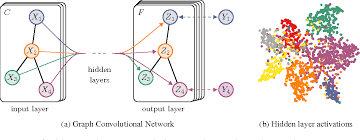

first, get users' behavior seq

second, generated item graph structure and get the adjacency matrix (A)

third, get the degree matrix (D)

forth, generated Laplacian matrix

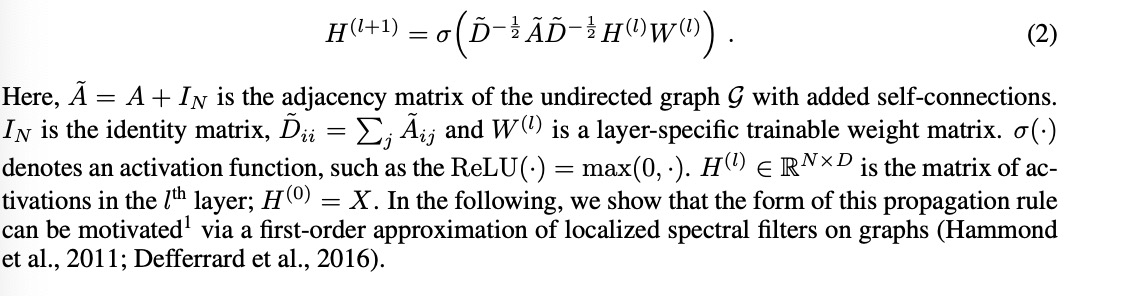

[know more about GCN](https://arxiv.org/pdf/1609.02907.pdf)


three ways to generated Laplacian matrix:
* combinatorial Laplacian

$L=D-A$

* symmetric normalized Laplacian

$L=D^{-0.5}*A*D^{-0.5}$

* randomwalk normalized Laplacian

$L=D^{-1}*A$


In [ ]:
!pip install annoy

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import warnings
from collections import defaultdict
import math
import pickle
import multitasking
import signal
from gensim.models import Word2Vec
import networkx as nx
from annoy import AnnoyIndex

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')
seed=2020

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
from networkx import to_numpy_matrix
def gcn_layer(G):
  order = sorted(list(G.nodes()))
  #get A
  A = to_numpy_matrix(G, nodelist=order)
  #get A_hat
  I = np.eye(G.number_of_nodes())
  A_hat = A + I
  #get D_hat
  D_hat = np.array(np.sum(A_hat, axis=0))[0]
  D_hat = np.matrix(np.diag(D_hat))
  
  W_1 = np.random.normal(loc=0, scale=1, size=(G.number_of_nodes(), 64))
  W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 32))

  def relu(x):
    return(abs(x)+x)/2

  def gcn_layer(A_hat, D_hat, X, W):
	  return relu(D_hat**-1 * A_hat * X * W)
   
  H_1 = gcn_layer(A_hat, D_hat, I, W_1)
  H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
  output = H_2
  feature_representations = {}
  nodes = list(G.nodes())
  for i in range(len(nodes)):
    feature_representations[nodes[i]] = np.array(output)[i]
  return feature_representations


In [ ]:
def gcn(df, user_col, item_col):
    user_item_ = df.groupby(user_col)[item_col].agg(list).reset_index()
    user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))
    edgelist = []
    user_time_ = df.groupby(user_col)['time'].agg(list).reset_index() 
    user_time_dict = dict(zip(user_time_[user_col], user_time_['time']))

    item_cnt=df[item_col].value_counts().to_dict()

    for user, items in user_item_dict.items():
        for i in range(len(items) - 1):
            t1 = user_time_dict[user][i] 
            t2 = user_time_dict[user][i+1]
            delta_t=abs(t1-t2)*50000   
            ai, aj = item_cnt[items[i]], item_cnt[items[i+1]]
            edgelist.append([items[i], items[i + 1], max(3, np.log(1+ai/aj)) * 1/(1+delta_t)])
            edgelist.append([items[i+1], items[i], max(3, np.log(1+aj/ai)) * 0.8 * 1/(1+delta_t)])
            
    G = nx.Graph()
    for edge in edgelist:
        G.add_edge(str(edge[0]), str(edge[1]), weight=edge[2])
    for u,v,d in G.edges(data=True):
        deg = G.degree(u)/G.degree(v)
        if deg < 1:
            deg = max(0.1, deg)
        else:
            deg = min(3, deg)
            new_weight = d["weight"] * deg
            G[u][v].update({"weight":new_weight})
    
    feature_representations= gcn_layer(G)
    return feature_representations
feature_representations=gcn(df_click, 'user_id', 'item_id')

In [ ]:
# setup index for feature_representations
index_to_item_dict = {}
item_to_index_dict = {}

item_index = AnnoyIndex(128, 'angular')
item_index.set_seed(2020)

for i, key in enumerate(feature_representations.keys()):
    emb = feature_representations[key]

    index_to_item_dict[i] = key
    item_to_index_dict[key] = i

    item_index.add_item(i, emb)

item_index.build(100)

In [ ]:
def rec9(df_qtime, user_embs, item_index, index_to_item_dict):
    data_list = []
    for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        user_emb = user_embs[user_id]
        ids, distances = item_index.get_nns_by_vector(user_emb,100,include_distances=True)
        item_ids = [index_to_item_dict[id] for id in ids]
        # the smaller distance, the higher score
        item_sim_scores = [2 - distance for distance in distances]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)

        df_temp = df_temp[['user_id', 'phase', 'query_time', 'item_id', 'sim_score', 'label']]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

    df_data = pd.concat(data_list, sort=False)
    return df_data

In [ ]:
@multitasking.task
def work(phase, force=False):
    os.makedirs('kdd2020_data/my_model/recall_9', exist_ok=True)

    if force or (not os.path.exists('kdd2020_data/my_model/recall_9/user_item_vec_{}.pkl'.format(phase))
                 or not os.path.exists('kdd2020_data/my_model/recall_9/recall_{}.pkl'.format(phase))):
      
        df_click_phase = df_click[df_click['phase'] == phase]

        tmp = df_click_phase.groupby('user_id', as_index=False)['item_id'].agg({'list': list})
        sentences = tmp['list'].values.tolist()
        del tmp['list']

        emb_matrix = []
        for seq in sentences:
            seq = seq[::-1]

            vec = []
            for pos, w in enumerate(seq):
                if w in item_vec_map.keys():
                    vec.append(np.asarray(item_vec_map[w]) * (0.7**pos))
            if len(vec) > 0:
            #we get the seq vec by average all the item's vec in the seq
                emb_matrix.append(np.mean(vec, axis=0))
            else:
                emb_matrix.append([0] * 128)

        df_user_txt_vec = tmp
        df_user_txt_vec['user_txt_vec'] = emb_matrix
        df_user_txt_vec['phase'] = phase
        df_user_txt_vec.to_pickle('kdd2020_data/my_model/recall_9/user_item_vec_{}.pkl'.format(phase))

        users = tmp['user_id'].values.tolist()
        user_embs = dict(zip(users, emb_matrix))

        df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
        df_data = rec3(df_qtime_phase, user_embs, item_index,index_to_item_dict)
        df_data.to_pickle('kdd2020_data/my_model/recall_9/recall_{}.pkl'.format(phase))

In [ ]:
item_sim_phase = {}
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
force = False

for phase in phases:
    work(phase, force)
    
multitasking.wait_for_tasks()
print('over')

In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]

    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']
                                        <= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
for phase in phases:
    df_data = pd.read_pickle('kdd2020_data/my_model/recall_9/recall_{}.pkl'.format(phase))
    df_recall = df_recall.append(df_data)

    score = evaluate_scores(df_data, phase)
    val_score += score

    print('phase', phase, score)
val_score

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_9.pkl')
df_recall.head()

# Recall_10

**The Common Neighbors algorithm**

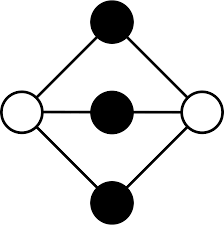

we don't calculate the sim of white circles directly, we caculate the sim of while and black circles instead.

[know about common neighbors algorithm](https://www.nature.com/articles/srep12261)

Adamic-Adar (AA)

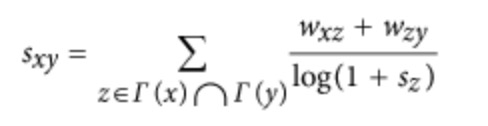

z:the common neighbor of x and y

w_xz:the sim of x and z

w_yz:the sim of y and z

s_z:denotes the strength of node z, namely the sum of weights of its associated links

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from collections import defaultdict  
import math  
import json
from sys import stdout
import pickle
import multitasking
import signal

multitasking.set_max_threads(10)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

<function _signal.default_int_handler>

In [ ]:
df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
phases = sorted(list(df_qtime['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
#RA、AA

input_path = 'kdd2020_data/my_model/recall_5/'
out_path = 'kdd2020_data/my_model/recall_10/'

for num in range(len(phases)):
    os.makedirs('kdd2020_data/my_model/recall_10/', exist_ok=True)
    
    # 获取itemCF相似度
    with open(input_path+'sim_'+str(num)+'.pkl','rb') as f:
        item_sim_dir= pickle.load(f)  
    
    item_sim = {}
    for item in item_sim_dir.keys():
        item_sim.setdefault(item, {})
        for related_item in item_sim_dir[item].keys():
            if item_sim_dir[item][related_item] > 0.005:
                item_sim[item][related_item] = item_sim_dir[item][related_item]
        
    strengh_dict = dict()
    print('Counting degree')
    for item in tqdm(item_sim):
        strengh_dict[item] = sum(item_sim[item].values())       
        
    strengh_AA_dict = dict()
    print('Counting degree')
    for item in tqdm(item_sim):
        strengh_AA_dict[item] = math.log(1+sum(item_sim[item].values()) )
        
        
    #RA
    RA_sim = dict()
    for item in tqdm(item_sim):
        neighbors = list(set(item_sim[item].keys()))
        for item1 in neighbors:
            if item in item_sim[item1]:
                RA_sim.setdefault(item1, {})
                for item2 in neighbors:
                    if item1 != item2:
                        RA_sim[item1].setdefault(item2, 0)
                        RA_sim[item1][item2] += item_sim[item1][item] * item_sim[item][item2]/strengh_dict[item]
    
    
    new_RA = dict()
    for item1 in tqdm(RA_sim):
        new_RA[item1] = {i: int(x * 1e3) / 1e3 for i, x in RA_sim[item1].items() if x > 1e-3}
    
  
    print('Saving')
    write_file = open(out_path+'RA_P'+str(num)+'_new.pkl', 'wb')
    pickle.dump(new_RA, write_file)
    write_file.close() 
        
    #AA
    AA_sim = dict()
    for item in tqdm(item_sim):
        neighbors = list(set(item_sim[item].keys()))
        for item1 in neighbors:
            if item in item_sim[item1]:
                AA_sim.setdefault(item1, {})
                for item2 in neighbors:
                    if item1 != item2:
                        AA_sim[item1].setdefault(item2, 0)
                        AA_sim[item1][item2] += item_sim[item1][item] * item_sim[item][item2]/strengh_AA_dict[item]
    
    
    new_AA = dict()
    for item1 in tqdm(AA_sim):
        new_AA[item1] = {i: int(x * 1e3) / 1e3 for i, x in AA_sim[item1].items() if x > 1e-3}
    
   
    print('Saving')
    write_file = open(out_path+'AA_P'+str(num)+'_new.pkl', 'wb')
    pickle.dump(new_AA, write_file)
    write_file.close()  
    

  0%|          | 0/40768 [00:00<?, ?it/s]

Counting degree
Counting degree


  8%|▊         | 3119/40768 [00:00<00:01, 31171.67it/s]

Saving


100%|██████████| 36487/36487 [00:00<00:00, 111489.54it/s]


Saving


100%|██████████| 41400/41400 [00:00<00:00, 436370.87it/s]

Counting degree
Counting degree



  0%|          | 0/41400 [00:00<?, ?it/s]

Saving


100%|██████████| 37026/37026 [00:00<00:00, 109411.92it/s]


Saving


  0%|          | 0/41024 [00:00<?, ?it/s]

Counting degree
Counting degree


  0%|          | 0/41024 [00:00<?, ?it/s]

Saving


100%|██████████| 36558/36558 [00:00<00:00, 108060.73it/s]


Saving


In [ ]:
def rec10(df_click_phase,df_qtime, sim_dict):
  user_item_ = df_click_phase.groupby('user_id')['item_id'].agg(lambda x: list(x)).reset_index()
  user_item_dict = dict(zip(user_item_['user_id'], user_item_['item_id']))
  
  data_list = []
  qtime_dict = dict(zip(df_qtime['user_id'], df_qtime['query_time']))

  for user_id, query_time, item_id, phase in tqdm(df_qtime.values):
        rank = {}
        for item in user_item_dict[user_id]:
            if item not in sim_dict.keys():
              continue
            for i in sim_dict[item].keys():
              if i in user_item_dict[user_id]:
                    continue
              if i not in rank.keys():
                    rank[i] = 0
              rank[i] += sim_dict[item][i]
        sim_items = sorted(rank.items(), key=lambda d: d[1],reverse=True)[:100]
        item_ids = [item[0] for item in sim_items]
        item_sim_scores = [item[1] for item in sim_items]

        df_temp = pd.DataFrame()
        df_temp['item_id'] = item_ids
        df_temp['sim_score'] = item_sim_scores
        df_temp['user_id'] = user_id
        df_temp['query_time'] = query_time
        df_temp['phase'] = phase

        if item_id == -1:
            df_temp['label'] = np.nan
        else:
            df_temp['label'] = 0
            df_temp.loc[df_temp['item_id'] == item_id, 'label'] = 1

        df_temp.sort_values(['sim_score'], inplace=True, ascending=False)
        df_temp = df_temp[[
            'user_id', 'phase', 'query_time', 'item_id', 'sim_score', 'label'
        ]]
        df_temp['user_id'] = df_temp['user_id'].astype('int')
        df_temp['item_id'] = df_temp['item_id'].astype('int')

        data_list.append(df_temp)

  df_data = pd.concat(data_list, sort=False)
  return df_data

In [ ]:
@multitasking.task
#recall depend on phase
def work(phase, force=False):
    df_click_phase = df_click[df_click['phase'] == phase]
    f = open('kdd2020_data/my_model/recall_10/AA_P{}_new.pkl'.format(phase), 'rb')
    sim_dir= pickle.load(f)
    f.close()
    df_qtime_phase = df_qtime[df_qtime['phase'] == phase]
    df_data = rec10(df_click_phase,df_qtime_phase, sim_dir)
    df_data.to_pickle('kdd2020_data/my_model/recall_10/recall_{}.pkl'.format(phase))
    print('phase {} finish'.format(phase))

In [ ]:
force = False
for phase in phases:
    work(phase, force)
    
multitasking.wait_for_tasks()
print('over')

100%|██████████| 18672/18672 [03:07<00:00, 99.81it/s] 


phase 1 finish
phase 2 finish
phase 0 finish
over


In [ ]:
def evaluate(df, median_item_degree, item_degree_map, num_cases_full, num_cases_half):
    gg = df.groupby(['user_id'])

    ndcg_50_full = 0.0
    hitrate_50_full = 0.0

    ndcg_50_half = 0.0
    hitrate_50_half = 0.0

    for _, g in tqdm(gg):
        try:
            item_id = g[g['label'] == 1]['item_id'].values[0]
            item_degree = item_degree_map[item_id]
        except Exception as e:
            continue

        predictions = g['item_id'].values.tolist()

        rank = 0
        while rank < 50 and predictions[rank] != item_id:
            rank += 1

        if rank < 50:
            ndcg_50_full += 1.0 / np.log2(rank + 2.0)
            hitrate_50_full += 1.0

        if item_degree <= median_item_degree:
            if rank < 50:
                ndcg_50_half += 1.0 / np.log2(rank + 2.0)
                hitrate_50_half += 1.0

    ndcg_50_full /= num_cases_full
    hitrate_50_full /= num_cases_full

    ndcg_50_half /= num_cases_half
    hitrate_50_half /= num_cases_half

    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
def evaluate_scores(df, phase):
    df_qtime = pd.read_pickle('kdd2020_data/recall/qtime.pkl')
    df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
    
    df_qtime = df_qtime[df_qtime['phase']==phase]
    df_click = df_click[df_click['phase']==phase]
    
    #filter traindata
    oof_answer = df_qtime[df_qtime['item_id'] != -1]
    num_cases_full = oof_answer.shape[0]

    answer_items = oof_answer['item_id'].values
    item_degree = df_click['item_id'].value_counts().reset_index()
    item_degree.columns = ['item_id', 'degree']

    answer_item_degree = item_degree[item_degree['item_id'].isin(answer_items)]
    list_item_degress = answer_item_degree['degree'].values.tolist()
    median_item_degree = list_item_degress[len(list_item_degress) // 2]
    item_degree_map = dict(zip(item_degree['item_id'], item_degree['degree']))
    num_cases_half = answer_item_degree[answer_item_degree['degree']<= median_item_degree].shape[0]

    ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half = evaluate(
        df, median_item_degree, item_degree_map, num_cases_full, num_cases_half)
    return ndcg_50_full, hitrate_50_full, ndcg_50_half, hitrate_50_half

In [ ]:
item_sim_phase = {}
df_recall = pd.DataFrame()
val_score = np.array([0.0, 0.0, 0.0, 0.0])
for phase in phases:
    f = open('kdd2020_data/my_model/recall_10/AA_P{}_new.pkl'.format(phase), 'rb')
    item_sim = pickle.load(f)
    f.close()
    df_data = pd.read_pickle('kdd2020_data/my_model/recall_10/recall_{}.pkl'.format(phase))
    item_sim_phase[phase] = item_sim
    df_recall = df_recall.append(df_data)
    score = evaluate_scores(df_data, phase)
    val_score += score
    print('phase', phase, score)

100%|██████████| 18422/18422 [00:16<00:00, 1115.93it/s]


phase 0 (0.033125216834393255, 0.08734117088231802, 0.03570359614246794, 0.09271997707079392)


100%|██████████| 18583/18583 [00:16<00:00, 1098.59it/s]


phase 1 (0.03440295633171705, 0.08639206892482001, 0.03717244407734193, 0.0901509705248023)


100%|██████████| 18316/18316 [00:16<00:00, 1094.34it/s]

phase 2 (0.03408970818197, 0.08893943021307159, 0.035767263456387095, 0.09156804733727811)


In [ ]:
f = open('kdd2020_data/my_model/sim10.pkl', 'wb')
pickle.dump(item_sim_phase, f)
f.close()
val_score

array([0.10161788, 0.26267267, 0.1086433 , 0.27443899])

In [ ]:
df_recall.sort_values(['user_id', 'phase', 'query_time'], inplace=True)
df_recall.to_pickle('kdd2020_data/my_model/recall_10.pkl')
df_recall.head()

,user_id,phase,query_time,item_id,sim_score,label
0,1,0.0,0.983942,95676,0.004,0.0
2,1,0.0,0.983942,103421,0.004,0.0
3,1,0.0,0.983942,46098,0.004,0.0
1,1,0.0,0.983942,68274,0.004,0.0
4,1,0.0,0.983942,102093,0.003,0.0


**more modes of common neighbors**

In [ ]:
# # CN、HPI、HDI、LHN1

# input_path = 'kdd2020_data/my_model/recall_5/'
# out_path = 'kdd2020_data/my_model/recall_10/'

# for num in range(now_phase+1):
    
#     with open(input_path+'sim_'+str(num)+'.pkl','rb') as f:
#         item_sim_list_tmp = pickle.load(f)  
    
#     item_sim = {}
#     for item in item_sim_list_tmp:
#         item_sim.setdefault(item, {})
#         for related_item in item_sim_list_tmp[item]:
#             if item_sim_list_tmp[item][related_item] > 0.005:
#                 item_sim[item][related_item] = item_sim_list_tmp[item][related_item]
    
#     item_sim_list_tmp = []
    
#     #CN
#     CN_sim = dict()
#     for item in tqdm(item_sim):
#         neighbors = list(set(item_sim[item].keys()))
#         for item1 in neighbors:
#             if item in item_sim[item1]:
#                 CN_sim.setdefault(item1, {})
#                 for item2 in neighbors:
#                     if item1 != item2:
#                         CN_sim[item1].setdefault(item2, 0)
#                         CN_sim[item1][item2] += item_sim[item1][item] * item_sim[item][item2]
    
    
#     new_CN = dict()
#     for item1 in tqdm(CN_sim):
#         new_CN[item1] = {i: int(x * 1e3) / 1e3 for i, x in CN_sim[item1].items() if x > 1e-3}
    
#     CN_sim = []
#     print('Saving')
#     write_file = open(out_path+'CN_P'+str(num)+'_new.pkl', 'wb')
#     pickle.dump(new_CN, write_file)
#     write_file.close() 
    
#     strengh_dict = dict()
#     print('Counting degree')
#     for item in tqdm(item_sim):
#         strengh_dict[item] = sum(item_sim[item].values())     
    
#     #HPI
#     HPI_sim = dict()
#     for item in tqdm(new_CN):
#         HPI_sim.setdefault(item,{})
#         for related_item in new_CN[item]:
#             HPI_sim[item][related_item] = new_CN[item][related_item]/max(0.005,min(strengh_dict[item],strengh_dict[related_item]))     
            
#     print('Saving')
#     write_file = open(out_path+'HPI_P'+str(num)+'_new.pkl', 'wb')
#     pickle.dump(HPI_sim, write_file)
#     write_file.close()
    
#     HPI_sim = []
    
    
#     #HDI
#     HDI_sim = dict()
#     for item in tqdm(new_CN):
#         HDI_sim.setdefault(item,{})
#         for related_item in new_CN[item]:
#             HDI_sim[item][related_item] = new_CN[item][related_item]/max(strengh_dict[item],strengh_dict[related_item])       
            
#     print('Saving')
#     write_file = open(out_path+'HDI_P'+str(num)+'_new.pkl', 'wb')
#     pickle.dump(HDI_sim, write_file)
#     write_file.close()    
#     HDI_sim = []
    
    
    
#     #LHN1
#     LHN1_sim = dict()
#     for item in tqdm(new_CN):
#         LHN1_sim.setdefault(item,{})
#         for related_item in new_CN[item]:
#             LHN1_sim[item][related_item] = new_CN[item][related_item]/( max(0.005,strengh_dict[item]) * max(0.005,strengh_dict[related_item]))       
            
#     print('Saving')
#     write_file = open(out_path+'LHN1_P'+str(num)+'_new.pkl', 'wb')
#     pickle.dump(LHN1_sim, write_file)
#     write_file.close()    
#     LHN1_sim = []
            
#     new_CN = []


Above all,we have recalled 1000 items for everyone in every phase.

# Preprocessing for rank

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import os
import warnings
from collections import defaultdict
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

warnings.filterwarnings('ignore')


In [ ]:
#combine recall
recall_1 = pd.read_pickle('kdd2020_data/my_model/recall_1.pkl')
recall_2 = pd.read_pickle('kdd2020_data/my_model/recall_2.pkl')
recall_3 = pd.read_pickle('kdd2020_data/my_model/recall_3.pkl')
recall_4 = pd.read_pickle('kdd2020_data/my_model/recall_4.pkl')
recall_5 = pd.read_pickle('kdd2020_data/my_model/recall_5.pkl')
recall_6 = pd.read_pickle('kdd2020_data/my_model/recall_6.pkl')
recall_7 = pd.read_pickle('kdd2020_data/my_model/recall_7.pkl')
recall_8 = pd.read_pickle('kdd2020_data/my_model/recall_8.pkl')
# recall_9 = pd.read_pickle('kdd2020_data/my_model/recall_9.pkl')
recall_10 = pd.read_pickle('kdd2020_data/my_model/recall_10.pkl')

recall_list = [recall_1, recall_2, recall_3, recall_4, recall_5, recall_6, recall_7, recall_8, recall_10]

In [ ]:
recall = pd.concat(recall_list, sort=False)
recall['phase'] = recall['phase'].astype('int')
del recall['sim_score']
recall.sort_values(['user_id', 'phase'], inplace=True)
print(recall.shape)
#drop repeated recall
recall.drop_duplicates(subset=['user_id', 'phase', 'item_id'], inplace=True)
print(recall.shape)
del recall_list,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6,recall_7,recall_8,recall_10
gc.collect()

(48702589, 5)
(33965132, 5)


341

In [ ]:
phases = sorted(list(recall['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
recall_hit_total = 0
for phase in phases:
    recall_phase = recall[recall['phase'] == phase]
    recall_hit = recall_phase[recall_phase['label'] == 1]['user_id'].nunique() / \
        recall_phase[recall_phase['label'].notnull()]['user_id'].nunique()
    recall_hit_total += recall_hit
    print('phase', phase, 'recall hit', recall_hit)
recall_hit_total

phase 0 recall hit 0.278232988956181
phase 1 recall hit 0.2759353239702585
phase 2 recall hit 0.285432128321762


0.8396004412482014

In [ ]:
for phase in phases:
    recall_phase = recall[recall['phase'] == phase]

    test_user_num = recall_phase[recall_phase['label'].isnull()]['user_id'].nunique()
    train_user_num = recall_phase[recall_phase['label'].notnull()]['user_id'].nunique()

    print('phase', phase, 'train_user_num',train_user_num, 'test_user_num', test_user_num)

phase 0 train_user_num 16842 test_user_num 1663
phase 1 train_user_num 16946 test_user_num 1726
phase 2 train_user_num 16708 test_user_num 1690


In [ ]:
recall.head()

,user_id,phase,query_time,item_id,label
0,1,0,0.9839419315,87837,0.0
1,1,0,0.9839419315,92349,0.0
2,1,0,0.9839419315,91290,0.0
3,1,0,0.9839419315,38168,0.0
4,1,0,0.9839419315,13663,0.0


In [ ]:
# if all of the 1000 recall's label are 0,drop them.
# this is every important, because we will use NN next.
gg = recall.groupby(['user_id', 'phase'])
useful_recall = []
for (user_id, phase), g in tqdm(gg):
    if g['label'].isnull().sum() > 0:
        useful_recall.append(g)
    else:
        label_sum = g['label'].sum()
        if label_sum > 1:
            print('error', user_id)
        elif label_sum == 1:
            useful_recall.append(g)

df_useful_recall = pd.concat(useful_recall, sort=False)

100%|██████████| 55575/55575 [00:35<00:00, 1584.67it/s]


In [ ]:
for phase in phases:
    recall_phase = df_useful_recall[df_useful_recall['phase'] == phase]

    test_user_num = recall_phase[recall_phase['label'].isnull()]['user_id'].nunique()
    train_user_num = recall_phase[recall_phase['label'].notnull()]['user_id'].nunique()

    print('phase', phase, 'train_user_num',train_user_num, 'test_user_num', test_user_num)

phase 0 train_user_num 4686 test_user_num 1663
phase 1 train_user_num 4676 test_user_num 1726
phase 2 train_user_num 4769 test_user_num 1690


In [ ]:
df_useful_recall.to_pickle('kdd2020_data/my_model/recall.pkl')

In [ ]:
df_useful_recall.head()

,user_id,phase,query_time,item_id,label
0,1,1,0.9839420823,101060,NaN
1,1,1,0.9839420823,102129,NaN
2,1,1,0.9839420823,94147,NaN
3,1,1,0.9839420823,92349,NaN
4,1,1,0.9839420823,87837,NaN


In [ ]:
df_useful_recall.shape

(11489051, 5)

In [ ]:
for phase in phases:
    recall_phase = df_useful_recall[df_useful_recall['phase'] == phase]
    df = recall_phase['user_id'].value_counts().reset_index()
    df.columns = ['user_id', 'cnt']
    print('phase', phase, df['cnt'].mean())

phase 0 597.7490943455663
phase 1 596.8211496407373
phase 2 599.6428239665582


In [ ]:
df_useful_recall[df_useful_recall['label'].notnull()].shape

(8384744, 5)

In [ ]:
df_useful_recall[df_useful_recall['label'].notnull()]['label'].value_counts()

0.0    8370613
1.0      14131
Name: label, dtype: int64

# Feature

In [ ]:
!pip install pandarallel

In [ ]:
import pandas as pd
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import gc
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import math
from pandarallel import pandarallel
import pickle
from gensim.models import Word2Vec
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pandarallel.initialize()
warnings.filterwarnings('ignore')
seed = 2020

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
df_feature = pd.read_pickle('kdd2020_data/my_model/recall.pkl')
print(df_feature.shape)

(11489051, 5)


In [ ]:
phases = sorted(list(df_feature['phase'].unique()))
phases

[0, 1, 2]

In [ ]:
df_item = pd.read_csv('kdd2020_data/underexpose_train/underexpose_item_feat.csv', header=None)
df_item.columns = ['item_id'] + ['txt_vec' +
                                 str(i) for i in range(128)] + ['img_vec'+str(i) for i in range(128)]
df_item['txt_vec0'] = df_item['txt_vec0'].apply(lambda x: float(x[1:]))
df_item['txt_vec127'] = df_item['txt_vec127'].apply(lambda x: float(x[:-1]))
df_item['img_vec0'] = df_item['img_vec0'].apply(lambda x: float(x[1:]))
df_item['img_vec127'] = df_item['img_vec127'].apply(lambda x: float(x[:-1]))
df_item.drop_duplicates(['item_id'], inplace=True)

In [ ]:
df_user = pd.read_csv('kdd2020_data/underexpose_train/underexpose_user_feat.csv', header=None)
df_user.columns = ['user_id', 'user_age_level','user_gender', 'user_city_level']

gender_map = {'F': 0, 'M': 1}
df_user['user_gender'] = df_user['user_gender'].map(gender_map)

df_user.drop_duplicates(['user_id'], inplace=True)

In [ ]:
#merge click info and user info
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
df_click = df_click.merge(df_user, how='left')

In [ ]:
print(df_click[:5])

   user_id  item_id      time  phase  user_age_level  user_gender  \
0        1    78142  0.983742      0             NaN          NaN   
1        1    26646  0.983757      0             NaN          NaN   
2        1    89568  0.983763      0             NaN          NaN   
3        1    76240  0.983770      0             NaN          NaN   
4        1    87533  0.983790      0             NaN          NaN   

   user_city_level  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  


In [ ]:
def group_func(df, group_func_dic, group_key):
    if isinstance(group_func_dic, str):
      group_func_dic = [group_func_dic]

    features = df.groupby(group_key).agg(group_func_dic)
    features.columns = ['_'.join(group_key) + '_' + e[0] + "_" + e[1]
                        for e in features.columns.tolist()]
    features.reset_index(inplace=True)
    return features

**item feature**

In [ ]:
#pca item info
from sklearn.decomposition import PCA
dim = 10
pca = PCA(n_components=dim, random_state=seed)
df_txt_pca = pd.DataFrame(pca.fit_transform(df_item[['txt_vec' + str(i) for i in range(128)]]))
df_txt_pca.columns = ['txt_vec{}_pca{}'.format(dim, i) for i in range(dim)]
df_txt_pca['item_id'] = df_item[['item_id']]
df_feature = df_feature.merge(df_txt_pca, how='left')

pca = PCA(n_components=dim, random_state=seed)
df_img_pca = pd.DataFrame(pca.fit_transform(
    df_item[['img_vec' + str(i) for i in range(128)]]))
df_img_pca.columns = ['img_vec{}_pca{}'.format(dim, i) for i in range(dim)]
df_img_pca['item_id'] = df_item[['item_id']]
df_feature = df_feature.merge(df_img_pca, how='left')
print(df_feature.columns)

Index(['user_id', 'phase', 'query_time', 'item_id', 'label', 'txt_vec10_pca0',
       'txt_vec10_pca1', 'txt_vec10_pca2', 'txt_vec10_pca3', 'txt_vec10_pca4',
       'txt_vec10_pca5', 'txt_vec10_pca6', 'txt_vec10_pca7', 'txt_vec10_pca8',
       'txt_vec10_pca9', 'img_vec10_pca0', 'img_vec10_pca1', 'img_vec10_pca2',
       'img_vec10_pca3', 'img_vec10_pca4', 'img_vec10_pca5', 'img_vec10_pca6',
       'img_vec10_pca7', 'img_vec10_pca8', 'img_vec10_pca9'],
      dtype='object')


In [ ]:
#item count
df_tmp = df_click.groupby(['phase', 'item_id']).size().reset_index()
df_tmp.columns = ['phase', 'item_id', 'phase_item_clickd_count']
df_feature = df_feature.merge(df_tmp, how='left',on=['phase', 'item_id'])
print(df_feature.shape)
del df_tmp
gc.collect()

(11489051, 26)


0

In [ ]:
# item time diff
df_temp = df_click[['phase', 'item_id', 'time']].copy()
df_temp.sort_values(['time'], inplace=True)
df_temp['phase_item_click_time_diff'] = df_temp.groupby(['item_id', 'phase'])['time'].diff()
df_temp = df_temp.groupby(['item_id','phase'])['phase_item_click_time_diff'].agg(phase_item_click_time_diff_mean='mean').reset_index()
df_feature = df_feature.merge(df_temp, how='left',on=['item_id','phase'])
print(df_feature.shape)
del df_temp
gc.collect()

(11489051, 27)


0

In [ ]:
# user age
group_func_dict = {'user_age_level': ['mean', 'min', 'max', 'std']}
df_temp = group_func(df_click, group_func_dict, group_key=['item_id', 'phase'])
df_feature = df_feature.merge(df_temp, how='left',on=['item_id', 'phase'])
del df_temp
gc.collect()
print(df_feature.shape)

(11489051, 31)


In [ ]:
#user gender
df_temp = df_click.groupby(['item_id', 'phase'])['user_gender'].mean().reset_index()
df_temp.columns = ['item_id', 'phase', 'phase_item_click_gender_mean']
df_feature = df_feature.merge(df_temp, how='left',on=['item_id', 'phase'])
del df_temp
gc.collect()
print(df_feature.shape)

(11489051, 32)


**user feature**

In [ ]:
df_feature = df_feature.merge(df_user, how='left')
print(df_feature.shape)

(11489051, 35)


In [ ]:
df_tmp = df_click.groupby(['user_id', 'phase']).size().reset_index()
df_tmp.columns = ['user_id', 'phase', 'phase_user_click_count']
df_feature = df_feature.merge(df_tmp, how='left',on=['user_id', 'phase'])
print(df_feature.shape)
del df_tmp
gc.collect()

df_tmp = df_click.groupby(['phase', 'user_age_level']).size().reset_index()
df_tmp.columns = ['phase', 'user_age_level','phase_user_age_level_click_count']
df_feature = df_feature.merge(df_tmp, how='left',on=['phase', 'user_age_level'])
print(df_feature.shape)
del df_tmp
gc.collect()

(11489051, 36)
(11489051, 37)


0

In [ ]:
group_func_dict = {'time': ['min', 'max', 'std']}
df_temp = group_func(df_click, group_func_dict, group_key=['user_id', 'phase'])
df_feature = df_feature.merge(df_temp, how='left',on=['user_id', 'phase'])
print(df_feature.shape)
del df_temp
gc.collect()

df_feature['user_id_phase_time_max_min_diff'] = df_feature['user_id_phase_time_max'] - \
    df_feature['user_id_phase_time_min']

df_feature['user_id_phase_query_lastbuy_time_diff'] = df_feature['query_time'] - \
    df_feature['user_id_phase_time_max']
print(df_feature.shape)

del df_feature['user_id_phase_time_max'], df_feature['user_id_phase_time_min']
gc.collect()

(11489051, 40)
(11489051, 42)


13

In [ ]:
df_feature.head()

,user_id,phase,query_time,item_id,label,txt_vec10_pca0,txt_vec10_pca1,txt_vec10_pca2,txt_vec10_pca3,txt_vec10_pca4,txt_vec10_pca5,txt_vec10_pca6,txt_vec10_pca7,txt_vec10_pca8,txt_vec10_pca9,img_vec10_pca0,img_vec10_pca1,img_vec10_pca2,img_vec10_pca3,img_vec10_pca4,img_vec10_pca5,img_vec10_pca6,img_vec10_pca7,img_vec10_pca8,img_vec10_pca9,phase_item_clickd_count,phase_item_click_time_diff_mean,item_id_phase_user_age_level_mean,item_id_phase_user_age_level_min,item_id_phase_user_age_level_max,item_id_phase_user_age_level_std,phase_item_click_gender_mean,user_age_level,user_gender,user_city_level,phase_user_click_count,phase_user_age_level_click_count,user_id_phase_time_std,user_id_phase_time_max_min_diff,user_id_phase_query_lastbuy_time_diff
0,1,1,0.983942,101060,NaN,-0.033200,6.758050,2.445827,-0.980435,-5.504060,-3.220289,3.175805,-3.443489,-3.544041,-1.404752,-1.080519,10.324701,0.737499,-5.772706,-5.054800,0.035968,3.500112,-4.218156,3.957114,2.160977,17.0,0.000009,3.571429,2.0,5.0,1.133893,0.00,NaN,NaN,NaN,9,NaN,0.000024,0.000094,1.507822e-07
1,1,1,0.983942,102129,NaN,-2.176809,4.566637,15.910588,-1.040885,-4.075056,4.052314,-4.776940,6.171880,1.471331,-0.046035,-3.046730,2.478535,-0.859532,-6.448319,2.800530,8.910352,-3.699516,-3.066158,-2.527535,-2.049918,17.0,0.000012,5.400000,4.0,8.0,1.673320,0.20,NaN,NaN,NaN,9,NaN,0.000024,0.000094,1.507822e-07
2,1,1,0.983942,94147,NaN,-9.188668,4.911909,3.100944,-5.318312,-2.562280,3.399558,0.779980,1.643967,-1.772803,-0.462451,-7.283262,1.301522,-3.056460,3.009867,1.882195,3.896656,-1.854984,8.029745,3.014313,2.492163,5.0,0.000039,2.000000,2.0,2.0,NaN,0.00,NaN,NaN,NaN,9,NaN,0.000024,0.000094,1.507822e-07
3,1,1,0.983942,92349,NaN,-4.942613,-4.970490,-4.758204,3.637302,-6.427946,-8.612261,-3.010530,-7.108364,2.320725,4.182026,0.793652,1.767247,4.539776,-7.067767,-6.766804,2.061429,0.491690,-5.229865,-1.015263,0.370548,14.0,0.000010,4.000000,3.0,5.0,0.816497,0.25,NaN,NaN,NaN,9,NaN,0.000024,0.000094,1.507822e-07
4,1,1,0.983942,87837,NaN,-13.042260,9.058986,-6.033150,-3.498339,-6.060202,-6.887897,-4.746740,-1.703656,2.524373,4.857164,-10.924910,6.915727,2.614477,-7.167866,-0.803820,0.644362,0.781104,-0.132394,-4.022217,0.235267,12.0,0.000018,3.500000,2.0,5.0,2.121320,0.00,NaN,NaN,NaN,9,NaN,0.000024,0.000094,1.507822e-07


In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature0.pkl')

**item-user feature**

we have three kinds of sim:

* dictionary:recall_1,recall_2,recall_5,recall_10

dictionary format:{phase:{item:{item1:score,item2:score}}}

* w2v model:recall_6,recall_7,recall_8

* dataframe:recall_3,recall_4

dataframe format:

dataframe[['item_id','item_txt/img_vec]]

dataframe[['user_id','user_txt/img_vec]]

In [ ]:
phase_user_item_dict = {}
for phase in phases:
    df_click_temp = df_click[df_click['phase'] == phase]
    user_item_ = df_click_temp.groupby('user_id')['item_id'].agg(list).reset_index()
    user_item_dict = dict(zip(user_item_['user_id'], user_item_['item_id']))
    phase_user_item_dict[phase] = user_item_dict

In [ ]:
def consine_distance(vector1, vector2):
    if type(vector1) != np.ndarray or type(vector2) != np.ndarray:
        return -1
    distance = np.dot(vector1, vector2) / \
        (np.linalg.norm(vector1)*(np.linalg.norm(vector2)))
    return distance

**sim1 from recall_1**

In [ ]:
f = open('kdd2020_data/my_model/sim1.pkl', 'rb')
item_sim_if = pickle.load(f)
f.close()

In [ ]:
def func_if_sum(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_if[phase][i][item_id] * (0.7**loc)
        except Exception as e:
            pass
    return sim_sum


def func_if_max(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1]

    sim_max = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim = item_sim_if[phase][i][item_id]
            if sim > sim_max:
                sim_max = sim
        except Exception as e:
            pass
    return sim_max


def func_if_last(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    last_item = phase_user_item_dict[phase][user_id][-1]

    sim = 0
    try:
        sim = item_sim_if[phase][last_item][item_id]
    except Exception as e:
        pass
    return sim


def func_if_rolling_sum(x, window):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[-window:]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_if[phase][i][item_id]
        except Exception as e:
            pass
    return sim_sum


def func_if_rolling_mean(x, window):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[-window:]

    sim_sum = 0
    count = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_if[phase][i][item_id]
            count += 1
        except Exception as e:
            pass
    if count != 0:
        return sim_sum / count
    else:
        return 0

In [ ]:
df_feature['user_click_item_if_sim_sum'] = df_feature[[
  'user_id', 'phase', 'item_id']].parallel_apply(func_if_sum, axis=1)
df_feature['user_click_item_if_sim_max'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_if_max, axis=1)
df_feature['user_last_click_item_if_sim'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_if_last, axis=1)

df_feature['user_click_item_if_sim_rolling2_sum'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_if_rolling_sum(x, 2), axis=1)
print(df_feature.shape)

(11489051, 44)


In [ ]:
del item_sim_if
gc.collect()

0

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature1.pkl')

**sim2 from recall_2**

In [ ]:
f = open('kdd2020_data/my_model/sim2.pkl', 'rb')
item_sim_bn = pickle.load(f)
f.close()

**based on the recall assessment results in recall, if the results is good,we adopt more features,otherwise we adopt fewer features**

In [ ]:
def func_bn_sum(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_bn[phase][i][item_id] * (0.7**loc)
        except Exception as e:
            pass
    return sim_sum

In [ ]:
df_feature['user_click_item_bn_sim_sum'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_bn_sum, axis=1)
print(df_feature.shape)

(11489051, 45)


In [ ]:
del item_sim_bn
gc.collect()

0

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature2.pkl')

**sim3 from recall_3(item txt sim)**

In [ ]:
df_user_txt_vec = pd.read_pickle('kdd2020_data/my_model/user_txt_vec.pkl')
df_item_txt_vec = pd.read_pickle('kdd2020_data/my_model/item_txt_vec.pkl')
item_txt_vec_dict = dict(zip(df_item_txt_vec['item_id'], df_item_txt_vec['item_txt_vec']))

phase_user_txt_vec_dict = {}
for phase in phases:
    df_user_txt_vec_phase = df_user_txt_vec[df_user_txt_vec['phase'] == phase]
    user_txt_vec_dict = dict(zip(df_user_txt_vec_phase['user_id'], df_user_txt_vec_phase['user_txt_vec']))
    phase_user_txt_vec_dict[phase] = user_txt_vec_dict

In [ ]:
def func_txt_sim(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    sim = 0
    try:
        sim = consine_distance(
            phase_user_txt_vec_dict[phase][user_id], item_txt_vec_dict[item_id])
    except Exception as e:
        pass
    return sim

In [ ]:
df_feature['user_item_txt_sim'] = df_feature[['user_id', 'phase', 'item_id']].parallel_apply(func_txt_sim, axis=1)
print(df_feature.shape)

(11489051, 46)


In [ ]:
def func_txt_sum(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += consine_distance(
                item_txt_vec_dict[i], item_txt_vec_dict[item_id]) * (0.7 ** loc)
        except Exception as e:
            pass
    return sim_sum


def func_txt_max(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1]

    sim_max = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim = consine_distance(
                item_txt_vec_dict[i], item_txt_vec_dict[item_id])
            if sim > sim_max:
                sim_max = sim
        except Exception as e:
            pass
    return sim_max


def func_txt_last(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    last_item = phase_user_item_dict[phase][user_id][-1]

    sim = 0
    try:
        sim = consine_distance(
            item_txt_vec_dict[last_item], item_txt_vec_dict[item_id])
    except Exception as e:
        pass
    return sim


def func_txt_rolling_sum(x, window):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[-window:]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += consine_distance(
                item_txt_vec_dict[i], item_txt_vec_dict[item_id])
        except Exception as e:
            pass
    return sim_sum


def func_txt_rolling_mean(x, window):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[-window:]

    sim_sum = 0
    count = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += consine_distance(
                item_txt_vec_dict[i], item_txt_vec_dict[item_id])
            count += 1
        except Exception as e:
            pass
    if count != 0:
        return sim_sum / count
    else:
        return 0

In [ ]:
df_feature['user_click_item_txt_sim_sum'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_txt_sum, axis=1)
print(df_feature.shape)
df_feature['user_click_item_txt_sim_max'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_txt_max, axis=1)
print(df_feature.shape)
df_feature['user_last_click_item_txt_sim'] = df_feature[[
    'user_id', 'phase',  'item_id']].parallel_apply(func_txt_last, axis=1)
print(df_feature.shape)

df_feature['user_click_item_txt_sim_rolling2_sum'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_txt_rolling_sum(x, 2), axis=1)
print(df_feature.shape)
df_feature['user_click_item_txt_sim_rolling2_mean'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_txt_rolling_mean(x, 2), axis=1)
print(df_feature.shape)
df_feature['user_click_item_txt_sim_rolling3_mean'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_txt_rolling_mean(x, 3), axis=1)
print(df_feature.shape)

(11489051, 47)
(11489051, 48)
(11489051, 49)
(11489051, 50)
(11489051, 51)
(11489051, 52)


In [ ]:
del df_user_txt_vec, df_item_txt_vec, phase_user_txt_vec_dict
gc.collect()

0

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature3.pkl')

**sim4 from recall_4(item img sim)**

In [ ]:
df_user_img_vec = pd.read_pickle('kdd2020_data/my_model/user_img_vec.pkl')
df_item_img_vec = pd.read_pickle('kdd2020_data/my_model/item_img_vec.pkl')
item_img_vec_dict = dict(
    zip(df_item_img_vec['item_id'], df_item_img_vec['item_img_vec']))

phase_user_img_vec_dict = {}
for phase in phases:
    df_user_img_vec_phase = df_user_img_vec[df_user_img_vec['phase'] == phase]
    user_img_vec_dict = dict(zip(df_user_img_vec['user_id'], df_user_img_vec['user_img_vec']))
    phase_user_img_vec_dict[phase] = user_txt_vec_dict

In [ ]:
def func_img_sim(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    sim = 0
    try:
        sim = consine_distance(
            phase_user_img_vec_dict[phase][user_id], item_img_vec_dict[item_id])
    except Exception as e:
        pass
    return sim

In [ ]:
df_feature['user_item_img_sim'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_img_sim, axis=1)
print(df_feature.shape)

(11489051, 53)


In [ ]:
del df_user_img_vec, df_item_img_vec, item_img_vec_dict, phase_user_img_vec_dict
gc.collect()

233

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature4.pkl')

**sim5 from recall_5**

In [ ]:
f = open('kdd2020_data/my_model/sim5.pkl', 'rb')
item_sim_tc = pickle.load(f)
f.close()

In [ ]:
def func_tc_sum(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_tc[phase][i][item_id]
        except Exception as e:
            pass
    return sim_sum


def func_tc_max(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1]

    sim_max = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim = item_sim_tc[phase][i][item_id]
            if sim > sim_max:
                sim_max = sim
        except Exception as e:
            pass
    return sim_max


def func_tc_rolling_sum(x, window):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[-window:]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_tc[phase][i][item_id]
        except Exception as e:
            pass
    return sim_sum

In [ ]:
df_feature['user_click_item_tc_sim_sum'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_tc_sum, axis=1)
df_feature['user_click_item_tc_sim_max'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_tc_max, axis=1)
df_feature['user_click_item_tc_sim_rolling2_sum'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_tc_rolling_sum(x, 2), axis=1)
print(df_feature.shape)

(11489051, 56)


In [ ]:
del item_sim_tc
gc.collect()

0

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature5.pkl')

**sim6 from recall_6(w2v)**

In [ ]:
df_feature=pd.read_pickle('kdd2020_data/recall/rank_feature5.pkl')

In [ ]:
from gensim.models import Word2Vec
def get_emb_dict(phase):
  model = Word2Vec.load('kdd2020_data/my_model/recall_6/w2v_{}.m'.format(phase))
  words=list(set(df_feature[df_feature['phase']==phase]['item_id'].tolist()))
  emb_matrix = []
  items = []
  for word in tqdm(words):
    if str(word) in model:
        items.append(word)
        emb_matrix.append(model[str(word)])
  item_w2w_vec_dict = dict(zip(items, emb_matrix))
  return item_w2w_vec_dict

In [ ]:
item_w2w_vec_dict_0=get_emb_dict(0)
item_w2w_vec_dict_1=get_emb_dict(1)
item_w2w_vec_dict_2=get_emb_dict(2)

100%|██████████| 108637/108637 [00:00<00:00, 182842.91it/s]


In [ ]:
# def get_emb_matrix(phase):
#   model = Word2Vec.load('kdd2020_data/my_model/w2v_{}.m'.format(phase))
#   words=list(set(df_feature[df_feature['phase']==phase]['item_id'].tolist()))
#   emb_matrix = []
#   items = []
#   for word in tqdm(words):
#     if str(word) in model:
#         items.append(word)
#         emb_matrix.append(model[str(word)])
#   item_w2w_vec_dict = dict(zip(items, emb_matrix))
#   df_item_w2v = pd.DataFrame(emb_matrix)
#   df_item_w2v.columns = ['item_w2v_{}'.format(i) for i in range(128)]
#   df_item_w2v['item_id'] = items
#   df_feature = df_feature.merge(df_item_w2v, how='left')
#   return df_feature

In [ ]:
def func_w2w_sum(x, num):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1][:num]
    
    if phase==0:
      item_w2w_vec_dict=item_w2w_vec_dict_0
    elif phase==1:
      item_w2w_vec_dict=item_w2w_vec_dict_1
    elif phase==2:
      item_w2w_vec_dict=item_w2w_vec_dict_2
    # item_w2w_vec_dict=get_emb_dict(phase)

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += consine_distance(
                item_w2w_vec_dict[item_id], item_w2w_vec_dict[i])
        except Exception as e:
            pass
    return sim_sum


def func_w2w_last_sim(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    last_item = phase_user_item_dict[phase][user_id][-1]
    # item_w2w_vec_dict=get_emb_dict(phase)

    if phase==0:
      item_w2w_vec_dict=item_w2w_vec_dict_0
    elif phase==1:
      item_w2w_vec_dict=item_w2w_vec_dict_1
    elif phase==2:
      item_w2w_vec_dict=item_w2w_vec_dict_2

    sim = 0
    try:
        sim = consine_distance(
            item_w2w_vec_dict[item_id], item_w2w_vec_dict[last_item])
    except Exception as e:
        pass
    return sim

In [ ]:
df_feature['user_last_click_item_w2w_sim'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_w2w_last_sim, axis=1) #run each row in parallel
df_feature['user_click_item_w2w_sim_sum_2'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_w2w_sum(x, 2), axis=1)
print(df_feature.shape)

(11489051, 58)


In [ ]:
del item_w2w_vec_dict_0,item_w2w_vec_dict_1,item_w2w_vec_dict_2
gc.collect()

86

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature6.pkl')

In [ ]:
print(df_feature[:5])

   user_id  phase  query_time  item_id  label  txt_vec10_pca0  txt_vec10_pca1  \
0        1      1    0.983942   101060    NaN       -0.033200        6.758050   
1        1      1    0.983942   102129    NaN       -2.176809        4.566637   
2        1      1    0.983942    94147    NaN       -9.188668        4.911909   
3        1      1    0.983942    92349    NaN       -4.942613       -4.970490   
4        1      1    0.983942    87837    NaN      -13.042260        9.058986   

   txt_vec10_pca2  txt_vec10_pca3  txt_vec10_pca4  txt_vec10_pca5  \
0        2.445827       -0.980435       -5.504060       -3.220289   
1       15.910588       -1.040885       -4.075056        4.052314   
2        3.100944       -5.318312       -2.562280        3.399558   
3       -4.758204        3.637302       -6.427946       -8.612261   
4       -6.033150       -3.498339       -6.060202       -6.887897   

   txt_vec10_pca6  txt_vec10_pca7  txt_vec10_pca8  txt_vec10_pca9  \
0        3.175805       -3.44

**sim7 from recall_7(deepwalk)**

In [ ]:
def get_emb_dict(phase):
  model = Word2Vec.load('kdd2020_data/my_model/recall_7/w2v_{}.m'.format(phase))
  words=list(set(df_feature[df_feature['phase']==phase]['item_id'].tolist()))
  emb_matrix = []
  items = []
  for word in tqdm(words):
    if str(word) in model:
        items.append(word)
        emb_matrix.append(model[str(word)])
  item_w2w_vec_dict = dict(zip(items, emb_matrix))
  return item_w2w_vec_dict

In [ ]:
item_w2w_vec_dict_0=get_emb_dict(0)
item_w2w_vec_dict_1=get_emb_dict(1)
item_w2w_vec_dict_2=get_emb_dict(2)

100%|██████████| 108637/108637 [00:00<00:00, 155447.56it/s]


In [ ]:
def func_w2w_sum(x, num):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1][:num]
    
    # item_w2w_vec_dict=get_emb_dict(phase)
    if phase==0:
      item_w2w_vec_dict=item_w2w_vec_dict_0
    elif phase==1:
      item_w2w_vec_dict=item_w2w_vec_dict_1
    elif phase==2:
      item_w2w_vec_dict=item_w2w_vec_dict_2

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += consine_distance(
                item_w2w_vec_dict[item_id], item_w2w_vec_dict[i])
        except Exception as e:
            pass
    return sim_sum


def func_w2w_last_sim(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    last_item = phase_user_item_dict[phase][user_id][-1]
    # item_w2w_vec_dict=get_emb_dict(phase)
    if phase==0:
      item_w2w_vec_dict=item_w2w_vec_dict_0
    elif phase==1:
      item_w2w_vec_dict=item_w2w_vec_dict_1
    elif phase==2:
      item_w2w_vec_dict=item_w2w_vec_dict_2

    sim = 0
    try:
        sim = consine_distance(
            item_w2w_vec_dict[item_id], item_w2w_vec_dict[last_item])
    except Exception as e:
        pass
    return sim

In [ ]:
df_feature['user_last_click_item_deepwalk_sim'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_w2w_last_sim, axis=1)
df_feature['user_click_item_deepwalk_sim_sum_2'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_w2w_sum(x, 2), axis=1)
print(df_feature.shape)

(11489051, 60)


In [ ]:
del item_w2w_vec_dict_0,item_w2w_vec_dict_1,item_w2w_vec_dict_2
gc.collect()

0

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature7.pkl')

**sim8 from recall_8(node2vec)**

In [ ]:
def get_emb_dict(phase):
  model = Word2Vec.load('kdd2020_data/my_model/recall_8/w2v_{}.m'.format(phase))
  words=list(set(df_feature[df_feature['phase']==phase]['item_id'].tolist()))
  emb_matrix = []
  items = []
  for word in tqdm(words):
    if str(word) in model:
        items.append(word)
        emb_matrix.append(model[str(word)])
  item_w2w_vec_dict = dict(zip(items, emb_matrix))
  return item_w2w_vec_dict

In [ ]:
item_w2w_vec_dict_0=get_emb_dict(0)
item_w2w_vec_dict_1=get_emb_dict(1)
item_w2w_vec_dict_2=get_emb_dict(2)

100%|██████████| 108637/108637 [00:00<00:00, 162142.74it/s]


In [ ]:
def func_w2w_sum(x, num):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1][:num]
    
    # item_w2w_vec_dict=get_emb_dict(phase)
    if phase==0:
      item_w2w_vec_dict=item_w2w_vec_dict_0
    elif phase==1:
      item_w2w_vec_dict=item_w2w_vec_dict_1
    elif phase==2:
      item_w2w_vec_dict=item_w2w_vec_dict_2

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += consine_distance(
                item_w2w_vec_dict[item_id], item_w2w_vec_dict[i])
        except Exception as e:
            pass
    return sim_sum


def func_w2w_last_sim(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    last_item = phase_user_item_dict[phase][user_id][-1]
    # item_w2w_vec_dict=get_emb_dict(phase)
    if phase==0:
      item_w2w_vec_dict=item_w2w_vec_dict_0
    elif phase==1:
      item_w2w_vec_dict=item_w2w_vec_dict_1
    elif phase==2:
      item_w2w_vec_dict=item_w2w_vec_dict_2

    sim = 0
    try:
        sim = consine_distance(
            item_w2w_vec_dict[item_id], item_w2w_vec_dict[last_item])
    except Exception as e:
        pass
    return sim

In [ ]:
df_feature['user_last_click_item_n2v_sim'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_w2w_last_sim, axis=1)
df_feature['user_click_item_n2v_sim_sum_2'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_w2w_sum(x, 2), axis=1)
print(df_feature.shape)

(11489051, 62)


In [ ]:
del item_w2w_vec_dict_0,item_w2w_vec_dict_1,item_w2w_vec_dict_2
gc.collect()

0

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature8.pkl')

**sim9 from recall_9(gcn)**

**sim10 from recall_10(common neighbors)**

In [ ]:
f = open('kdd2020_data/my_model/sim10.pkl', 'rb')
item_sim_if = pickle.load(f)
f.close()

In [ ]:
def func_if_sum(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_if[phase][i][item_id] * (0.7**loc)
        except Exception as e:
            pass
    return sim_sum


def func_if_max(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[::-1]

    sim_max = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim = item_sim_if[phase][i][item_id]
            if sim > sim_max:
                sim_max = sim
        except Exception as e:
            pass
    return sim_max


def func_if_last(x):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    last_item = phase_user_item_dict[phase][user_id][-1]

    sim = 0
    try:
        sim = item_sim_if[phase][last_item][item_id]
    except Exception as e:
        pass
    return sim


def func_if_rolling_sum(x, window):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[-window:]

    sim_sum = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_if[phase][i][item_id]
        except Exception as e:
            pass
    return sim_sum


def func_if_rolling_mean(x, window):
    user_id = x['user_id']
    item_id = x['item_id']
    phase = x['phase']

    interacted_items = phase_user_item_dict[phase][user_id]
    interacted_items = interacted_items[-window:]

    sim_sum = 0
    count = 0
    for loc, i in enumerate(interacted_items):
        try:
            sim_sum += item_sim_if[phase][i][item_id]
            count += 1
        except Exception as e:
            pass
    if count != 0:
        return sim_sum / count
    else:
        return 0

In [ ]:
df_feature['user_click_item_common_sim_sum'] = df_feature[[
  'user_id', 'phase', 'item_id']].parallel_apply(func_if_sum, axis=1)
df_feature['user_click_item_common_sim_max'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_if_max, axis=1)
df_feature['user_last_click_common_if_sim'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(func_if_last, axis=1)

df_feature['user_click_item_common_sim_rolling2_sum'] = df_feature[[
    'user_id', 'phase', 'item_id']].parallel_apply(lambda x: func_if_rolling_sum(x, 2), axis=1)
print(df_feature.shape)

(11489051, 66)


In [ ]:
del item_sim_if
gc.collect()

0

In [ ]:
df_feature.to_pickle('kdd2020_data/recall/rank_feature10.pkl')

**plus a low dimension embedding**

In [ ]:
df_feature=pd.read_pickle('kdd2020_data/recall/rank_feature10.pkl')

In [ ]:
emb_size = 8
#it will be better to adopt a bigger num 
tmp = df_click.groupby(['user_id', 'phase'], as_index=False)['item_id'].agg({'list': list})
sentences = tmp['list'].values.tolist()
words = []
for i in range(len(sentences)):
    words += [x for x in sentences[i]]
    sentences[i] = [str(x) for x in sentences[i]]

if os.path.exists('kdd2020_data/recall/word2vec.model'):
    model = Word2Vec.load('kdd2020_data/recall/word2vec.model')
else:
    model = Word2Vec(sentences, size=emb_size, window=10,
                     min_count=1, sg=1, hs=1, seed=seed)
    model.save('kdd2020_data/recall/word2vec.model')

emb_matrix = []
words = list(set(words))
items = []
for word in tqdm(words):
    if str(word) in model:
        items.append(word)
        emb_matrix.append(model[str(word)])
        
item_w2w_vec_dict = dict(zip(items, emb_matrix))
df_item_w2v = pd.DataFrame(emb_matrix)
df_item_w2v.columns = ['item_w2v_{}'.format(i) for i in range(emb_size)]
df_item_w2v['item_id'] = items
df_feature = df_feature.merge(df_item_w2v, how='left')
print(df_feature.shape)

100%|██████████| 61894/61894 [00:00<00:00, 91218.62it/s]


(11489051, 74)


In [ ]:
print(df_feature[:5])

   user_id  phase    query_time  item_id  label  txt_vec10_pca0  \
0        1      1  0.9839420823   101060    NaN   -0.0332000578   
1        1      1  0.9839420823   102129    NaN   -2.1768086403   
2        1      1  0.9839420823    94147    NaN   -9.1886678487   
3        1      1  0.9839420823    92349    NaN   -4.9426130199   
4        1      1  0.9839420823    87837    NaN  -13.0422602060   

   txt_vec10_pca1  txt_vec10_pca2  txt_vec10_pca3  txt_vec10_pca4  \
0    6.7580501287    2.4458265697   -0.9804350560   -5.5040604974   
1    4.5666371248   15.9105881809   -1.0408846348   -4.0750558759   
2    4.9119086750    3.1009435427   -5.3183116031   -2.5622802797   
3   -4.9704899321   -4.7582041896    3.6373023621   -6.4279457169   
4    9.0589856870   -6.0331498105   -3.4983394658   -6.0602022344   

   txt_vec10_pca5  txt_vec10_pca6  txt_vec10_pca7  txt_vec10_pca8  \
0   -3.2202888321    3.1758053886   -3.4434892283   -3.5440414567   
1    4.0523142690   -4.7769398462    6.17188

In [ ]:
print(df_feature.columns)

Index(['user_id', 'phase', 'query_time', 'item_id', 'label', 'txt_vec10_pca0',
       'txt_vec10_pca1', 'txt_vec10_pca2', 'txt_vec10_pca3', 'txt_vec10_pca4',
       'txt_vec10_pca5', 'txt_vec10_pca6', 'txt_vec10_pca7', 'txt_vec10_pca8',
       'txt_vec10_pca9', 'img_vec10_pca0', 'img_vec10_pca1', 'img_vec10_pca2',
       'img_vec10_pca3', 'img_vec10_pca4', 'img_vec10_pca5', 'img_vec10_pca6',
       'img_vec10_pca7', 'img_vec10_pca8', 'img_vec10_pca9',
       'phase_item_clickd_count', 'phase_item_click_time_diff_mean',
       'item_id_phase_user_age_level_mean', 'item_id_phase_user_age_level_min',
       'item_id_phase_user_age_level_max', 'item_id_phase_user_age_level_std',
       'phase_item_click_gender_mean', 'user_age_level', 'user_gender',
       'user_city_level', 'phase_user_click_count',
       'phase_user_age_level_click_count', 'user_id_phase_time_std',
       'user_id_phase_time_max_min_diff',
       'user_id_phase_query_lastbuy_time_diff', 'user_click_item_if_sim_sum',
   

In [ ]:
del item_w2w_vec_dict,df_item_w2v
gc.collect()
df_feature.to_pickle('kdd2020_data/recall/rank_feature11.pkl')

# Rank_1

**LSTM**

In [ ]:
import numpy as np 
import pandas as pd
import sklearn
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import gc
from collections import defaultdict  
import math  
import random
from random import sample

# -*- coding: utf-8 -*-
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Input,Convolution1D,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten,concatenate,Embedding,GRU,Lambda, LSTM, TimeDistributed
from keras.layers.merge import Concatenate
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model,Model
from keras.layers import Dense, Embedding, LSTM,Flatten,BatchNormalization
from gensim.models import word2vec 
import keras
import time
from keras.optimizers import *
from keras.callbacks import *
pd.set_option('display.max_rows',200)

import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
whole_click = pd.DataFrame()  
for c in range(3):  
    click_train = pd.read_csv('kdd2020_data/underexpose_train/underexpose_train_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    click_test = pd.read_csv('kdd2020_data/underexpose_test/underexpose_test_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    all_click = click_train.append(click_test)  
    whole_click = whole_click.append(all_click)  

whole_click = whole_click.drop_duplicates(subset=['user_id','item_id','time'])
whole_click = whole_click.sort_values('time',ascending=True)   
whole_click = whole_click.reset_index(drop=True)
for col in ['item_id','time']:#,'time_interval_cumsum']:
    whole_click[col]=whole_click[col].astype(str)

whole_item_df = whole_click.groupby('user_id').agg(
                                item_list = pd.NamedAgg(column = 'item_id',aggfunc=(lambda x : list(x))),
                                time_list = pd.NamedAgg(column = 'time',aggfunc=(lambda x : list(x))),
                                ).reset_index()

In [ ]:
#generate positive samples
positive_df = []
#for each seq, we only consider of last 5 words
last_n = 5
for i in tqdm(whole_item_df.index):
    user_id = whole_item_df.loc[i,'user_id']
    item_list = whole_item_df.loc[i,'item_list']
    time_list = whole_item_df.loc[i,'time_list']
    if len(item_list)<=1: 
        continue
    if len(item_list)<last_n: 
        for j in range(3,len(item_list)+1):
            positive_df.append([user_id,' '.join(item_list[:j]),time_list[j-1]])
    else:
        for j in range(3,last_n):
            positive_df.append([user_id,' '.join(item_list[:j]),time_list[j-1]])
        for j in range(last_n,len(item_list)+1,1):
            recent_item_list = item_list[j-last_n:j]
            positive_df.append([user_id,' '.join(recent_item_list),time_list[j-1]])

100%|██████████| 23816/23816 [00:01<00:00, 15331.45it/s]


In [ ]:
#the last one as label
train_set_df_p = pd.DataFrame(positive_df,columns=['user_id','recent_items','time'])
train_set_df_p['label'] = 1
train_set_df_p['target_item'] = train_set_df_p['recent_items'].apply(lambda x : x.split(' ')[-1])
train_set_df_p['recent_items'] = train_set_df_p['recent_items'].apply(lambda x : ' '.join(x.split(' ')[:-1]))

In [ ]:
#generate negative samples 50:1
negative_ratio = 50
negative_list = whole_click['item_id'].sample(len(train_set_df_p)*negative_ratio,replace=True).values.tolist()
train_set_df = train_set_df_p[['user_id','time','target_item','label']].copy()
for i in tqdm(range(negative_ratio)):
    tmp_negative_list = negative_list[i*len(train_set_df_p):(i+1)*len(train_set_df_p)]
    tmp_df = train_set_df_p[['user_id','time','target_item','label']].copy()
    tmp_df['target_item']=tmp_negative_list
    tmp_df['label'] = 0
    train_set_df=train_set_df.append(tmp_df,ignore_index=True)

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


In [ ]:
#combine user info
user_data = pd.read_csv('kdd2020_data/underexpose_train/underexpose_user_feat.csv',names=['user_id', 'user_age_level', 'user_gender', 'user_city_level'])
user_data = pd.concat([user_data,pd.get_dummies(user_data['user_gender'])],axis=1)
user_data = user_data.drop_duplicates(subset=['user_id'])
user_data.drop(columns=['user_gender'],inplace=True)

train_set_df_p = train_set_df_p.merge(user_data,on='user_id',how='left')

scaler_user = sklearn.preprocessing.StandardScaler()
scaler_user.fit(train_set_df_p[['user_age_level', 'user_city_level','F', 'M']])
train_set_df_p[['user_age_level', 'user_city_level','F', 'M']] = scaler_user.transform(train_set_df_p[['user_age_level', 'user_city_level','F', 'M']])

train_set_df_p['user_age_level'].fillna(0,inplace=True)
train_set_df_p['user_city_level'].fillna(0,inplace=True)
train_set_df_p['F'].fillna(0,inplace=True)
train_set_df_p['M'].fillna(0,inplace=True)

In [ ]:
#filter the click who's occur time after qtime
test_query = pd.DataFrame()
for c in range(3):  
    tmp_query = pd.read_csv('kdd2020_data/underexpose_test/underexpose_test_qtime-{}.csv'.format(c), header=None,  names=['user_id', 'query_time'])  
    test_query = test_query.append(tmp_query,ignore_index=True)
    
whole_click=whole_click.sort_values(by =['user_id','time'],ascending=False).reset_index(drop=True)    
whole_click['time']=whole_click['time'].astype('float64')
recent_items_df = pd.DataFrame()
for i in tqdm(test_query.index):
    user = test_query.loc[i,'user_id']
    time = test_query.loc[i,'query_time']
    time_left = str(whole_click.loc[(whole_click['user_id']==user)&(whole_click['time']<time)]['time'].max())
    time_right =  str(whole_click.loc[(whole_click['user_id']==user)&(whole_click['time']>time)]['time'].min())
    recent_items_df =recent_items_df.append([{'user_id':user,'time':time_left,'isval':1},{'user_id':user,'time':time_right,'isval':2}],ignore_index=True)
recent_items_df = recent_items_df[recent_items_df['time']!='nan']
train_set_df = train_set_df.merge(recent_items_df,on=['user_id','time'],how='left')

100%|██████████| 5079/5079 [00:30<00:00, 168.74it/s]


In [ ]:
test_set_df = train_set_df[train_set_df['isval']==1].reset_index(drop=True)
train_set_df = train_set_df[train_set_df['isval'].isnull()].reset_index(drop=True)

#train:val=19:1
val_data_ratio = 20
random.seed(2020)
sample_ind = sample(range(train_set_df.label.sum()),train_set_df.label.sum()//val_data_ratio)
train_sample_ind = list(set(list(range(train_set_df.label.sum()))) - set(sample_ind))
val_sample_ind = sample_ind[:len(sample_ind)]

val_sample_ind_all = []
for i in range(negative_ratio+1):
    tmp_ind = np.add(val_sample_ind,train_set_df.label.sum()*i)
    val_sample_ind_all.extend(tmp_ind)

train_sample_ind_all = []
for i in range(negative_ratio+1):
    tmp_ind = np.add(train_sample_ind,train_set_df.label.sum()*i)
    train_sample_ind_all.extend(tmp_ind)
    

test_len = test_set_df.shape[0]
train_set_df = train_set_df.append(test_set_df,ignore_index=True)

In [ ]:
whole_item_df['item_list'] = whole_item_df['item_list'].apply(lambda x : ' '.join([str(i) for i in x]))
max_word_len = whole_click.item_id.nunique()
tokenizer = Tokenizer(num_words=max_word_len, split=' ')
tokenizer.fit_on_texts(whole_item_df['item_list'])
recent_items_list = pad_sequences(tokenizer.texts_to_sequences(train_set_df_p['recent_items']))
train_set_df_p['recent_items5'] = recent_items_list.tolist()
train_set_df['target_item'] = pad_sequences(tokenizer.texts_to_sequences(train_set_df['target_item'])).tolist()

In [ ]:
test_set_df = train_set_df[-test_len:]
val_set_df = train_set_df.loc[val_sample_ind_all]
train_set_df = train_set_df.loc[train_sample_ind_all]

In [ ]:
train_set_df['target']=train_set_df['target_item'].apply(lambda x :x[0])
train_set_df.drop_duplicates(subset=['user_id','time','target'],keep='first',inplace=True)
train_set_df.drop(columns=['target','isval'],inplace = True)

val_set_df['target']=val_set_df['target_item'].apply(lambda x :x[0])
val_set_df.drop_duplicates(subset=['user_id','time','target'],keep='first',inplace=True)
val_set_df.drop(columns=['target','isval'],inplace = True)

test_set_df['target']=test_set_df['target_item'].apply(lambda x :x[0])
test_set_df.drop_duplicates(subset=['user_id','time','target'],keep='first',inplace=True)
test_set_df.drop(columns=['target','isval'],inplace = True)

train_set_df = train_set_df.reset_index(drop=True)
val_set_df = val_set_df.reset_index(drop=True)
test_set_df = test_set_df.reset_index(drop=True)

train_set_df_p.drop(columns=['target_item','label'],inplace=True,errors='ignore')

In [ ]:
class data_generator:
    def __init__(self, data, batch_size=128):
        self.data = data
        self.batch_size = batch_size
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
    def __len__(self):
        return self.steps

    def __iter__(self):
        global train_set_df_p
        while True:
            train_set = self.data
            idxs = list(range(len(self.data)))
            np.random.shuffle(idxs)
            index_list = []
            X1,  X3 ,Y = [], [], []
            for c, i in enumerate(idxs):
                index_list.append(i)
                if len(index_list) == self.batch_size or i == idxs[-1]:
                    tmp_df = train_set.loc[index_list]
                    tmp_df = tmp_df.merge(train_set_df_p,on=['user_id','time'])
                    tmp_df['recent_items5'] = tmp_df['recent_items5']+tmp_df['target_item']
                    X1 = np.array(tmp_df['recent_items5'].values.tolist())
                    X3 = np.array(tmp_df[['user_age_level', 'user_city_level','F', 'M']].values.tolist())
                    Y = np.array(tmp_df['label'].values.tolist())
                    yield [X1,X3], Y
                    tmp_df = pd.DataFrame()
                    X1, X3 ,Y = [],  [] ,[]
                    index_list = []

In [ ]:
last_n=5
embed_size=32
model = Sequential()
seq = Input(shape=[last_n])
emb = Embedding(
           max_word_len+1,       
           embed_size,                
           trainable=True)(seq)       
lstm_1 = LSTM(embed_size, input_shape=(last_n, embed_size),return_sequences=True)(emb)
lstm_2 = LSTM(embed_size)(lstm_1)
input_2 = Input(shape=[4,])
merge = concatenate([lstm_2,input_2])
mlp = Dense(units=100,activation='relu')(merge)
mlp = Dropout(0.3)(mlp)
mlp=  BatchNormalization()(mlp)
output = Dense(units=1,activation='sigmoid')(mlp)

model = Model([seq,input_2],output)
print(model.summary())
model.compile( optimizer=keras.optimizers.RMSprop(1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC()])

filepath = "kdd2020_data/recall/lstm_.h5" 
monitor_name = 'val_auc_1'
checkpoint = ModelCheckpoint(
    filepath, monitor=monitor_name, verbose=1, save_best_only=True, mode='max')
reduce_lr2 = ReduceLROnPlateau(
    monitor=monitor_name, factor=0.8, patience=1, min_lr=0.0001, verbose=1)
earlystopping2 = EarlyStopping(
    monitor=monitor_name, min_delta=0.0001, patience=2, verbose=1, mode='max')
callbacks2 = [checkpoint, earlystopping2 ,reduce_lr2]
train_D = data_generator(train_set_df,batch_size=8192)
valid_D = data_generator(val_set_df,batch_size=8192)
model.fit_generator(train_D.__iter__(),validation_data=valid_D.__iter__(),validation_steps=len(valid_D),steps_per_epoch=len(train_D),epochs=10, shuffle=True,callbacks=callbacks2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 32)        1980992     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 32)        8320        embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 32)           8320        lstm_1[0][0]                     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
2496/2496 [==============================] - 728s 292ms/step - loss: 0.1099 - auc_1: 0.5001 - val_loss: 0.1022 - val_auc_1: 0.5000

Epoch 00001: val_auc_1 improved from -inf to 0.50000, saving model to kdd2020_data/recall/lstm_.h5
Epoch 2/10
2496/2496 [==============================] - 727s 291ms/step - loss: 0.0966 - auc_1: 0.5003 - val_loss: 0.1116 - val_auc_1: 0.5000

Epoch 00002: val_auc_1 did not improve from 0.50000

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 3/10
2496/2496 [==============================] - 719s 288ms/step - loss: 0.0966 - auc_1: 0.5001 - val_loss: 0.1048 - val_auc_1: 0.5000

Epoch 00003: val_auc_1 did not improve from 0.50000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 00003: early stopping


In [ ]:
test_D = data_generator(test_set_df.reset_index(drop=True),batch_size=8192)
model.evaluate_generator(test_D.__iter__(),steps=len(test_D))
model = load_model('kdd2020_data/recall/lstm_.h5',compile=False)
model.compile( optimizer=keras.optimizers.RMSprop(1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC()])

In [ ]:
def get_feature(train_set_df , query_df,whole_click,isval=False):
    recent_items_df = pd.DataFrame()
    last_n=5
    for i in tqdm(query_df.index):
        user = query_df.loc[i,'user_id']
        time = query_df.loc[i,'query_time']
        phase = query_df.loc[i,'phase']
        recent_items = ' '.join([str(i) for i in  whole_click.loc[(whole_click['user_id']==user)&(whole_click['time']<time)&(whole_click['phase']==phase)]['item_id'][:last_n-1].values.tolist()[::-1]])
        recent_items_df = recent_items_df.append({'user_id':user,'query_time':time,'recent_items_5':recent_items,'phase':phase},ignore_index=True)
    train_set_df = train_set_df.merge(recent_items_df,on=['user_id','query_time','phase'])
    train_set_df['recent_items_5'] = train_set_df['recent_items_5']+' '+ train_set_df['item_id'].astype(str)
#     tokenizer = joblib.load('./tokenizer.m')
#     scaler_user = joblib.load('./user_info_std_scalar.m')
    user_data = pd.read_csv('kdd2020_data/underexpose_train/underexpose_user_feat.csv',names=['user_id', 'user_age_level', 'user_gender', 'user_city_level'])
    user_data = pd.concat([user_data,pd.get_dummies(user_data['user_gender'])],axis=1)
    user_data = user_data.drop_duplicates(subset=['user_id'])
    user_data.drop(columns=['user_gender'],inplace=True)
    train_set_df = train_set_df.merge(user_data,on='user_id',how='left')
    train_set_df[['user_age_level', 'user_city_level','F', 'M']] = scaler_user.transform(train_set_df[['user_age_level', 'user_city_level','F', 'M']])
    train_set_df['user_age_level'].fillna(0,inplace=True)
    train_set_df['user_city_level'].fillna(0,inplace=True)
    train_set_df['F'].fillna(0,inplace=True)
    train_set_df['M'].fillna(0,inplace=True)
    X = tokenizer.texts_to_sequences(train_set_df['recent_items_5'])
    X = pad_sequences(X)
    if isval:
        return X,train_set_df[['user_age_level', 'user_city_level','F', 'M']],train_set_df['label']
        #return train_set_df
    else:
        return X,train_set_df[['user_age_level', 'user_city_level','F', 'M']]

In [ ]:
final_recall = pd.read_pickle('kdd2020_data/my_model/recall.pkl')
final_recall = final_recall[['user_id', 'phase', 'query_time', 'item_id', 'label']]
train_set_df = final_recall[~final_recall['label'].isnull()].reset_index(drop=True)
test_set_df = final_recall[final_recall['label'].isnull()].reset_index(drop=True)
query_df = train_set_df[train_set_df['label']==1]


whole_click = pd.DataFrame()  
for c in range(3):  
    click_train = pd.read_csv('kdd2020_data/underexpose_train/underexpose_train_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    click_test = pd.read_csv('kdd2020_data/underexpose_test/underexpose_test_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    all_click = click_train.append(click_test)  
    all_click['phase']=c
    whole_click = whole_click.append(all_click)  
whole_click = whole_click.drop_duplicates(subset=['user_id','item_id','time','phase'])
whole_click = whole_click.sort_values(by =['user_id','time'],ascending=False).reset_index(drop=True)

In [ ]:
X_1,X_2,y = get_feature(train_set_df,query_df,whole_click,isval=True)
train_set_df['pred'] = model.predict([X_1,X_2],batch_size=4096)

100%|██████████| 14131/14131 [01:59<00:00, 118.35it/s]


In [ ]:
test_query = test_set_df.drop_duplicates(['user_id','phase','query_time'])
test_x_1,test_x_2 =get_feature(whole_click=whole_click,train_set_df=test_set_df,query_df=test_query,isval=False,)
test_set_df['pred'] = model.predict([test_x_1,test_x_2 ],batch_size=4096)

100%|██████████| 5079/5079 [00:42<00:00, 120.44it/s]


In [ ]:
data_all = train_set_df.append(test_set_df,ignore_index=True)
data_all.to_pickle('kdd2020_data/recall/lstm_rank.pkl')

# Rank_2

**transformer**

In [ ]:
import numpy as np 
import pandas as pd
import sklearn
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import gc
from collections import defaultdict  
import math  
import random
from random import sample

# -*- coding: utf-8 -*-
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Input,Convolution1D,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten,concatenate,Embedding,GRU,Lambda, LSTM, TimeDistributed
from keras.layers.merge import Concatenate
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model,Model
from keras.layers import Dense, Embedding, LSTM,Flatten,BatchNormalization
from gensim.models import word2vec 
import keras
import time
from keras.optimizers import *
from keras.callbacks import *
pd.set_option('display.max_rows',200)

import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
whole_click = pd.DataFrame()  
for c in range(3):  
    click_train = pd.read_csv('kdd2020_data/underexpose_train/underexpose_train_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    click_test = pd.read_csv('kdd2020_data/underexpose_test/underexpose_test_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    all_click = click_train.append(click_test)  
    whole_click = whole_click.append(all_click)  

whole_click = whole_click.drop_duplicates(subset=['user_id','item_id','time'])
whole_click = whole_click.sort_values('time',ascending=True)   
whole_click = whole_click.reset_index(drop=True)
for col in ['item_id','time']:#,'time_interval_cumsum']:
    whole_click[col]=whole_click[col].astype(str)

whole_item_df = whole_click.groupby('user_id').agg(
                                item_list = pd.NamedAgg(column = 'item_id',aggfunc=(lambda x : list(x))),
                                time_list = pd.NamedAgg(column = 'time',aggfunc=(lambda x : list(x))),
                                ).reset_index()

In [ ]:
#generate positive samples
positive_df = []
#for each seq, we only consider of last 5 words
last_n = 5
for i in tqdm(whole_item_df.index):
    user_id = whole_item_df.loc[i,'user_id']
    item_list = whole_item_df.loc[i,'item_list']
    time_list = whole_item_df.loc[i,'time_list']
    if len(item_list)<=1: 
        continue
    if len(item_list)<last_n: 
        for j in range(3,len(item_list)+1):
            positive_df.append([user_id,' '.join(item_list[:j]),time_list[j-1]])
    else:
        for j in range(3,last_n):
            positive_df.append([user_id,' '.join(item_list[:j]),time_list[j-1]])
        for j in range(last_n,len(item_list)+1,1):
            recent_item_list = item_list[j-last_n:j]
            positive_df.append([user_id,' '.join(recent_item_list),time_list[j-1]])

100%|██████████| 23816/23816 [00:01<00:00, 15343.91it/s]


In [ ]:
#the last one as label
train_set_df_p = pd.DataFrame(positive_df,columns=['user_id','recent_items','time'])
train_set_df_p['label'] = 1
train_set_df_p['target_item'] = train_set_df_p['recent_items'].apply(lambda x : x.split(' ')[-1])
train_set_df_p['recent_items'] = train_set_df_p['recent_items'].apply(lambda x : ' '.join(x.split(' ')[:-1]))

In [ ]:
#generate negative samples 50:1
negative_ratio = 50
negative_list = whole_click['item_id'].sample(len(train_set_df_p)*negative_ratio,replace=True).values.tolist()
train_set_df = train_set_df_p[['user_id','time','target_item','label']].copy()
for i in tqdm(range(negative_ratio)):
    tmp_negative_list = negative_list[i*len(train_set_df_p):(i+1)*len(train_set_df_p)]
    tmp_df = train_set_df_p[['user_id','time','target_item','label']].copy()
    tmp_df['target_item']=tmp_negative_list
    tmp_df['label'] = 0
    train_set_df=train_set_df.append(tmp_df,ignore_index=True)

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


In [ ]:
#combine user info
user_data = pd.read_csv('kdd2020_data/underexpose_train/underexpose_user_feat.csv',names=['user_id', 'user_age_level', 'user_gender', 'user_city_level'])
user_data = pd.concat([user_data,pd.get_dummies(user_data['user_gender'])],axis=1)
user_data = user_data.drop_duplicates(subset=['user_id'])
user_data.drop(columns=['user_gender'],inplace=True)

train_set_df_p = train_set_df_p.merge(user_data,on='user_id',how='left')

scaler_user = sklearn.preprocessing.StandardScaler()
scaler_user.fit(train_set_df_p[['user_age_level', 'user_city_level','F', 'M']])
train_set_df_p[['user_age_level', 'user_city_level','F', 'M']] = scaler_user.transform(train_set_df_p[['user_age_level', 'user_city_level','F', 'M']])

train_set_df_p['user_age_level'].fillna(0,inplace=True)
train_set_df_p['user_city_level'].fillna(0,inplace=True)
train_set_df_p['F'].fillna(0,inplace=True)
train_set_df_p['M'].fillna(0,inplace=True)

In [ ]:
#filter the click who's occur time after qtime
test_query = pd.DataFrame()
for c in range(3):  
    tmp_query = pd.read_csv('kdd2020_data/underexpose_test/underexpose_test_qtime-{}.csv'.format(c), header=None,  names=['user_id', 'query_time'])  
    test_query = test_query.append(tmp_query,ignore_index=True)
    
whole_click=whole_click.sort_values(by =['user_id','time'],ascending=False).reset_index(drop=True)    
whole_click['time']=whole_click['time'].astype('float64')
recent_items_df = pd.DataFrame()
for i in tqdm(test_query.index):
    user = test_query.loc[i,'user_id']
    time = test_query.loc[i,'query_time']
    time_left = str(whole_click.loc[(whole_click['user_id']==user)&(whole_click['time']<time)]['time'].max())
    time_right =  str(whole_click.loc[(whole_click['user_id']==user)&(whole_click['time']>time)]['time'].min())
    recent_items_df =recent_items_df.append([{'user_id':user,'time':time_left,'isval':1},{'user_id':user,'time':time_right,'isval':2}],ignore_index=True)
recent_items_df = recent_items_df[recent_items_df['time']!='nan']
train_set_df = train_set_df.merge(recent_items_df,on=['user_id','time'],how='left')

100%|██████████| 5079/5079 [00:29<00:00, 172.10it/s]


In [ ]:
test_set_df = train_set_df[train_set_df['isval']==1].reset_index(drop=True)
train_set_df = train_set_df[train_set_df['isval'].isnull()].reset_index(drop=True)

#train:val=19:1
val_data_ratio = 20
random.seed(2020)
sample_ind = sample(range(train_set_df.label.sum()),train_set_df.label.sum()//val_data_ratio)
train_sample_ind = list(set(list(range(train_set_df.label.sum()))) - set(sample_ind))
val_sample_ind = sample_ind[:len(sample_ind)]

val_sample_ind_all = []
for i in range(negative_ratio+1):
    tmp_ind = np.add(val_sample_ind,train_set_df.label.sum()*i)
    val_sample_ind_all.extend(tmp_ind)

train_sample_ind_all = []
for i in range(negative_ratio+1):
    tmp_ind = np.add(train_sample_ind,train_set_df.label.sum()*i)
    train_sample_ind_all.extend(tmp_ind)
    

test_len = test_set_df.shape[0]
train_set_df = train_set_df.append(test_set_df,ignore_index=True)

In [ ]:
whole_item_df['item_list'] = whole_item_df['item_list'].apply(lambda x : ' '.join([str(i) for i in x]))
max_word_len = whole_click.item_id.nunique()
tokenizer = Tokenizer(num_words=max_word_len, split=' ')
tokenizer.fit_on_texts(whole_item_df['item_list'])
recent_items_list = pad_sequences(tokenizer.texts_to_sequences(train_set_df_p['recent_items']))
train_set_df_p['recent_items5'] = recent_items_list.tolist()
train_set_df['target_item'] = pad_sequences(tokenizer.texts_to_sequences(train_set_df['target_item'])).tolist()

In [ ]:
test_set_df = train_set_df[-test_len:]
val_set_df = train_set_df.loc[val_sample_ind_all]
train_set_df = train_set_df.loc[train_sample_ind_all]

In [ ]:
train_set_df['target']=train_set_df['target_item'].apply(lambda x :x[0])
train_set_df.drop_duplicates(subset=['user_id','time','target'],keep='first',inplace=True)
train_set_df.drop(columns=['target','isval'],inplace = True)

val_set_df['target']=val_set_df['target_item'].apply(lambda x :x[0])
val_set_df.drop_duplicates(subset=['user_id','time','target'],keep='first',inplace=True)
val_set_df.drop(columns=['target','isval'],inplace = True)

test_set_df['target']=test_set_df['target_item'].apply(lambda x :x[0])
test_set_df.drop_duplicates(subset=['user_id','time','target'],keep='first',inplace=True)
test_set_df.drop(columns=['target','isval'],inplace = True)

train_set_df = train_set_df.reset_index(drop=True)
val_set_df = val_set_df.reset_index(drop=True)
test_set_df = test_set_df.reset_index(drop=True)

train_set_df_p.drop(columns=['target_item','label'],inplace=True,errors='ignore')

In [ ]:
class data_generator:
    def __init__(self, data, batch_size=128):
        self.data = data
        self.batch_size = batch_size
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
    def __len__(self):
        return self.steps

    def __iter__(self):
        global train_set_df_p
        while True:
            train_set = self.data
            idxs = list(range(len(self.data)))
            np.random.shuffle(idxs)
            index_list = []
            X1,  X3 ,Y = [], [], []
            for c, i in enumerate(idxs):
                index_list.append(i)
                if len(index_list) == self.batch_size or i == idxs[-1]:
                    tmp_df = train_set.loc[index_list]
                    tmp_df = tmp_df.merge(train_set_df_p,on=['user_id','time'])
                    tmp_df['recent_items5'] = tmp_df['recent_items5']+tmp_df['target_item']
                    X1 = np.array(tmp_df['recent_items5'].values.tolist())
                    X3 = np.array(tmp_df[['user_age_level', 'user_city_level','F', 'M']].values.tolist())
                    Y = np.array(tmp_df['label'].values.tolist())
                    yield [X1,X3], Y
                    tmp_df = pd.DataFrame()
                    X1, X3 ,Y = [],  [] ,[]
                    index_list = []

In [ ]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass

embed_size = 32
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        outputs = Add()([outputs, q])
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn

class DecoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_att_layer  = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, dec_input, enc_output, self_mask=None, enc_mask=None):
        output, slf_attn = self.self_att_layer(dec_input, dec_input, dec_input, mask=self_mask)
        output, enc_attn = self.enc_att_layer(output, enc_output, enc_output, mask=enc_mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn, enc_attn

def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Encoder():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, \
                layers=6, dropout=0.1, word_emb=None, pos_emb=None):
        self.emb_layer = word_emb
        self.pos_layer = pos_emb
        self.emb_dropout = Dropout(dropout)
        self.layers = [EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout) for _ in range(layers)]
        
    def __call__(self, src_seq, src_pos, return_att=False, active_layers=999):
        x = self.emb_layer(src_seq)
        if src_pos is not None:
            pos = self.pos_layer(src_pos)
            x = Add()([x, pos])
        x = self.emb_dropout(x)
        if return_att: atts = []
        mask = Lambda(lambda x:GetPadMask(x, x))(src_seq)
        for enc_layer in self.layers[:active_layers]:
            x, att = enc_layer(x, mask)
            if return_att: atts.append(att)
        return (x, atts) if return_att else x


class Transformer():
    def __init__(self, len_limit, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = True
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb) # Add embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None,))
        src_seq = src_seq_input
        src_pos = Lambda(self.get_pos_seq)(src_seq)
        if not self.src_loc_info: src_pos = None

        x = self.encoder(src_seq, src_pos, active_layers=active_layers)
        # x = GlobalMaxPool1D()(x) # Not sure about this layer. Just wanted to reduce dimension
        x = GlobalAveragePooling1D()(x)
        input_2=Input(shape=[4,])
        merge = concatenate([x,input_2])
        mlp = Dense(units=100,activation='relu')(merge)
        mlp = Dropout(0.3)(mlp)
        outp = Dense(units=1,activation='sigmoid')(mlp)  

        self.model = Model(inputs=[src_seq_input,input_2], outputs=outp)
        # self.model.compile(optimizer=keras.optimizers.RMSprop(1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC()])

In [ ]:
maxlen=5
max_features=max_word_len+1
s2s = Transformer(maxlen, layers=1)
s2s.compile()
model = s2s.model
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None)         0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 32)     1980992     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     160         lambda_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
filepath = "kdd2020_data/recall/attention_.h5" 
monitor_name = 'val_auc_1'
checkpoint = ModelCheckpoint(
    filepath, monitor=monitor_name, verbose=1, save_best_only=False,save_weights_only=True,mode='max')
reduce_lr2 = ReduceLROnPlateau(
    monitor=monitor_name, factor=0.8, patience=1, min_lr=0.0001, verbose=1)
earlystopping2 = EarlyStopping(
    monitor=monitor_name, min_delta=0.0001, patience=2, verbose=1, mode='max')
callbacks2 = [earlystopping2 ,reduce_lr2]
train_D = data_generator(train_set_df,batch_size=8192)
valid_D = data_generator(val_set_df,batch_size=8192)
model.fit_generator(train_D.__iter__(),validation_data=valid_D.__iter__(),validation_steps=len(valid_D),steps_per_epoch=len(train_D),epochs=10, shuffle=True,callbacks=callbacks2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
2496/2496 [==============================] - 752s 301ms/step - loss: 0.0982 - auc_1: 0.4997 - val_loss: 0.1160 - val_auc_1: 0.5000
Epoch 2/10
2496/2496 [==============================] - 722s 289ms/step - loss: 0.0974 - auc_1: 0.4996 - val_loss: 0.0896 - val_auc_1: 0.5000

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 3/10
2496/2496 [==============================] - 717s 287ms/step - loss: 0.0971 - auc_1: 0.4997 - val_loss: 0.0897 - val_auc_1: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 00003: early stopping


In [ ]:
test_D = data_generator(test_set_df.reset_index(drop=True),batch_size=8192)
model.evaluate_generator(test_D.__iter__(),steps=len(test_D))
# model = load_model('kdd2020_data/recall/attention_.h5',compile=False)
# model.compile( optimizer=keras.optimizers.RMSprop(1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC()])

[0.0772295594215393, 0.5000154972076416]

In [ ]:
def get_feature(train_set_df , query_df,whole_click,isval=False):
    recent_items_df = pd.DataFrame()
    last_n=5
    for i in tqdm(query_df.index):
        user = query_df.loc[i,'user_id']
        time = query_df.loc[i,'query_time']
        phase = query_df.loc[i,'phase']
        recent_items = ' '.join([str(i) for i in  whole_click.loc[(whole_click['user_id']==user)&(whole_click['time']<time)&(whole_click['phase']==phase)]['item_id'][:last_n-1].values.tolist()[::-1]])
        recent_items_df = recent_items_df.append({'user_id':user,'query_time':time,'recent_items_5':recent_items,'phase':phase},ignore_index=True)
    train_set_df = train_set_df.merge(recent_items_df,on=['user_id','query_time','phase'])
    train_set_df['recent_items_5'] = train_set_df['recent_items_5']+' '+ train_set_df['item_id'].astype(str)
#     tokenizer = joblib.load('./tokenizer.m')
#     scaler_user = joblib.load('./user_info_std_scalar.m')
    user_data = pd.read_csv('kdd2020_data/underexpose_train/underexpose_user_feat.csv',names=['user_id', 'user_age_level', 'user_gender', 'user_city_level'])
    user_data = pd.concat([user_data,pd.get_dummies(user_data['user_gender'])],axis=1)
    user_data = user_data.drop_duplicates(subset=['user_id'])
    user_data.drop(columns=['user_gender'],inplace=True)
    train_set_df = train_set_df.merge(user_data,on='user_id',how='left')
    train_set_df[['user_age_level', 'user_city_level','F', 'M']] = scaler_user.transform(train_set_df[['user_age_level', 'user_city_level','F', 'M']])
    train_set_df['user_age_level'].fillna(0,inplace=True)
    train_set_df['user_city_level'].fillna(0,inplace=True)
    train_set_df['F'].fillna(0,inplace=True)
    train_set_df['M'].fillna(0,inplace=True)
    X = tokenizer.texts_to_sequences(train_set_df['recent_items_5'])
    X = pad_sequences(X)
    if isval:
        return X,train_set_df[['user_age_level', 'user_city_level','F', 'M']],train_set_df['label']
        #return train_set_df
    else:
        return X,train_set_df[['user_age_level', 'user_city_level','F', 'M']]

In [ ]:
final_recall = pd.read_pickle('kdd2020_data/my_model/recall.pkl')
final_recall = final_recall[['user_id', 'phase', 'query_time', 'item_id', 'label']]
train_set_df = final_recall[~final_recall['label'].isnull()].reset_index(drop=True)
test_set_df = final_recall[final_recall['label'].isnull()].reset_index(drop=True)
query_df = train_set_df[train_set_df['label']==1]


whole_click = pd.DataFrame()  
for c in range(3):  
    click_train = pd.read_csv('kdd2020_data/underexpose_train/underexpose_train_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    click_test = pd.read_csv('kdd2020_data/underexpose_test/underexpose_test_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    all_click = click_train.append(click_test)  
    all_click['phase']=c
    whole_click = whole_click.append(all_click)  
whole_click = whole_click.drop_duplicates(subset=['user_id','item_id','time','phase'])
whole_click = whole_click.sort_values(by =['user_id','time'],ascending=False).reset_index(drop=True)

In [ ]:
X_1,X_2,y = get_feature(train_set_df,query_df,whole_click,isval=True)
train_set_df['pred'] = model.predict([X_1,X_2],batch_size=4096)

100%|██████████| 14131/14131 [01:59<00:00, 118.15it/s]


In [ ]:
test_query = test_set_df.drop_duplicates(['user_id','phase','query_time'])
test_x_1,test_x_2 =get_feature(whole_click=whole_click,train_set_df=test_set_df,query_df=test_query,isval=False)
test_set_df['pred'] = model.predict([test_x_1,test_x_2],batch_size=4096)

100%|██████████| 5079/5079 [00:41<00:00, 121.54it/s]


In [ ]:
data_all = train_set_df.append(test_set_df,ignore_index=True)
data_all.to_pickle('kdd2020_data/recall/transformer_rank.pkl')

# Rank_3

**target attention** 

In [ ]:
import pandas as pd
df_data = pd.read_pickle('kdd2020_data/recall/rank_feature11.pkl')
df_history = pd.read_pickle('kdd2020_data/recall/click.pkl')

In [ ]:
df_data['user_phase'] = df_data['user_id'].astype('str') + '_' + df_data['phase'].astype('str')
df_history['user_phase'] = df_history['user_id'].astype('str') + '_' + df_history['phase'].astype('str')

In [ ]:
print(df_history.shape)
df_history = df_history[df_history['user_phase'].isin(df_data['user_phase'].values)]
print(df_history.shape)

(745415, 5)
(280239, 5)


In [ ]:
df_history.sort_values(['user_id', 'time'], inplace=True)

In [ ]:
df_temp = df_history.groupby(['user_phase'])['item_id'].agg(history=list).reset_index()

In [ ]:
df_temp.head()

,user_phase,history
0,10001_2,"[58374, 15105, 9978, 25595, 66100, 82523, 7536..."
1,10004_2,"[35531, 11683, 12916, 66435, 23362, 85444, 764..."
2,10005_0,"[93726, 8048, 66055, 68189, 76335, 46620, 3978..."
3,10005_2,"[12691, 63720, 74150, 113203, 27093, 63486, 48..."
4,10007_1,"[53651, 111664, 93799]"


In [ ]:
df_data = df_data.merge(df_temp, how='left')
del df_data['user_phase']

In [ ]:
# Function to reduce the memory usage
import pandas as pd
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import gc
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import math
import pickle
from gensim.models import Word2Vec
import os

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm([f for f in df.columns if f not in ['query_time']]):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
df_data=reduce_mem_usage(df_data)

100%|██████████| 74/74 [00:32<00:00,  2.26it/s]

Mem. usage decreased to 1895.53 Mb (71.5% reduction)


In [ ]:
df_data.to_pickle('kdd2020_data/recall/nn_input.pkl')
print(df_data.shape)

(11489051, 75)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers import *
from keras import backend as BKD
import keras.backend.tensorflow_backend as TFBKD
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
import gensim
import gc
import time
pd.set_option('display.max_columns', None)
tqdm.pandas(desc='pandas bar')

import logging
logging.basicConfig(
    level=logging.DEBUG,
    filename='logging_log.txt',
    filemode='w',
    format= '%(asctime)s - %(pathname)s[line:%(lineno)d] - %(levelname)s: %(message)s'
)

Using TensorFlow backend.


In [ ]:
df = pd.read_pickle('kdd2020_data/recall/nn_input.pkl')
print(df.shape)

(11489051, 75)


In [ ]:
embedding_size=2
emb_size = embedding_size
sentences = df.drop_duplicates(['user_id', 'phase'])['history'].values.tolist()
print(len(sentences))
for i in tqdm(range(len(sentences))):
    sentences[i] = [str(x) for x in sentences[i]]
model = Word2Vec(sentences, size=emb_size, window=5, min_count=1, sg=1, hs=0, iter=5, seed=2020, workers=12)
del sentences
gc.collect()

100%|██████████| 19210/19210 [00:00<00:00, 204646.97it/s]

19210


0

In [ ]:
words = set()
for line in tqdm(df['history'].values):
    words |= set(line)
words = np.sort(list(words))
print(words[:10])
vocab_size = len(words)
words_idx_dict = dict(zip(words, range(vocab_size)))

100%|██████████| 11489051/11489051 [00:13<00:00, 850222.43it/s]


[ 1  3  9 10 14 18 19 20 21 22]


In [ ]:
emb_size = embedding_size
embedding_matrix = np.zeros((vocab_size + 1, emb_size))
for w in tqdm(words_idx_dict.keys()):
    if str(w) in model:
        embedding_matrix[words_idx_dict[w] + 1] = model[str(w)]
embedding_matrix = embedding_matrix.astype(np.float32)

  0%|          | 0/56098 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 56098/56098 [00:01<00:00, 48306.92it/s]


In [ ]:
max_len=5
df['history'] = df['history'].progress_apply(lambda seq: [words_idx_dict[int(x)] + 1 for x in seq])
df['history'] = df['history'].progress_apply(
    lambda seq: seq[-max_len:] if len(seq) >= max_len else seq + ([0] * (max_len - len(seq))))


pandas bar: 100%|██████████| 11489051/11489051 [00:29<00:00, 389389.04it/s]


In [ ]:
class TargetAttentionLayer(Layer):
    def __init__(self, n_steps, embedding_size, hidden_dim, random_state, **kwargs):
        self.n_steps = n_steps
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim
        self.random_state = random_state
        super(TargetAttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(self.embedding_size, self.hidden_dim),
            initializer=keras.initializers.truncated_normal(stddev=0.1, seed=self.random_state),
            trainable=True
        )
        self.W_BIAS = self.add_weight(
            name='W_BIAS',
            shape=(self.hidden_dim,),
            initializer=keras.initializers.Constant(value=0.1),
            trainable=True
        )
        self.O = self.add_weight(
            name='O',
            shape=(self.hidden_dim, 1),
            initializer=keras.initializers.truncated_normal(stddev=0.1, seed=self.random_state),
            trainable=True
        )
        self.O_BIAS = self.add_weight(
            name='O_BIAS',
            shape=(1,),
            initializer=keras.initializers.Constant(value=0.1),
            trainable=True
        )
        super(TargetAttentionLayer, self).build(input_shape)
    
    def call(self, x):
        his_embedding_vectors, target_embedding_vector, mask = x
        mask = BKD.reshape(mask, [-1, 1, self.n_steps])
        target_embedding_vector = BKD.tile(target_embedding_vector, [1, self.n_steps, 1])
        diff = his_embedding_vectors - target_embedding_vector
        attention_vec = concatenate([his_embedding_vectors, diff, target_embedding_vector], axis=2)
        alpha = BKD.relu(BKD.bias_add(BKD.dot(attention_vec, self.W), self.W_BIAS))
        alpha = BKD.bias_add(BKD.dot(alpha, self.O), self.O_BIAS)
        alpha = BKD.permute_dimensions(alpha, [0, 2, 1]) - mask * 1e10
        attention = BKD.batch_dot(BKD.softmax(alpha), his_embedding_vectors)
        return BKD.squeeze(attention, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][2])


class SelfAttentionLayer(Layer):
    def __init__(self, head_count, n_steps, embedding_size, QKV_dim, random_state, **kwargs):
        self.head_count = head_count
        self.n_steps = n_steps
        self.embedding_size = embedding_size
        self.QKV_dim = QKV_dim
        self.random_state = random_state
        super(SelfAttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.WQ, self.WK, self.WV = [], [], []
        for i in range(self.head_count):
            self.WQ.append(
                self.add_weight(
                    name='WQ{}'.format(i),
                    shape=(self.embedding_size, self.QKV_dim),
                    initializer=keras.initializers.truncated_normal(stddev=0.1, seed=self.random_state),
                    trainable=True
                )
            )
            self.WK.append(
                self.add_weight(
                    name='WK{}'.format(i),
                    shape=(self.embedding_size, self.QKV_dim),
                    initializer=keras.initializers.truncated_normal(stddev=0.1, seed=self.random_state),
                    trainable=True
                )
            )
            self.WV.append(
                self.add_weight(
                    name='WV{}'.format(i),
                    shape=(self.embedding_size, self.QKV_dim),
                    initializer=keras.initializers.truncated_normal(stddev=0.1, seed=self.random_state),
                    trainable=True
                )
            )
        self.BE = self.add_weight(
            name='BE',
            shape=(self.n_steps, self.embedding_size),
            initializer=keras.initializers.truncated_normal(stddev=0.1, seed=self.random_state),
            trainable=True
        )
        self.WO = self.add_weight(
            name='WO',
            shape=(self.head_count * self.QKV_dim, self.embedding_size),
            initializer=keras.initializers.truncated_normal(stddev=0.1, seed=self.random_state),
            trainable=True
        )
        super(SelfAttentionLayer, self).build(input_shape)
    
    def call(self, x):
        his_embedding_vectors, mask = x
        mask = BKD.reshape(mask, [-1, 1, self.n_steps])
        mask = BKD.tile(mask, [1, self.n_steps, 1])
        his_embedding_vectors = his_embedding_vectors + self.BE
        attention = []
        for i in range(self.head_count):
            Q = BKD.dot(his_embedding_vectors, self.WQ[i])
            K = BKD.dot(his_embedding_vectors, self.WK[i])
            V = BKD.dot(his_embedding_vectors, self.WV[i])
            alpha = BKD.batch_dot(Q, BKD.permute_dimensions(K, [0, 2, 1])) / np.sqrt(self.embedding_size)
            alpha = BKD.softmax(alpha - mask * 1e10)
            attention.append(BKD.batch_dot(alpha, V))
        if self.head_count > 1:
            attention = concatenate(attention, axis=2)
        else:
            attention = attention[0]
        return BKD.dot(attention, self.WO)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2])


def TargetAttentionNet(
    n_steps, vocab_size, embedding_matrix_init, embedding_size, feats_dim,
    head_count, QKV_dim, attention_hidden_dim=32, output_dim=2, random_state=None
):



    X_HIS = Input(shape=(n_steps,), dtype='int32')
    X_MASK = Input(shape=(n_steps,), dtype='float32')
    X_TARGET = Input(shape=(1,), dtype='int32')
    X_FEATS = Input(shape=(feats_dim,), dtype='float32')
    
    embedding_matrix = Embedding(
        input_dim=vocab_size+1,
        output_dim=embedding_size,
        embeddings_initializer=keras.initializers.Constant(value=embedding_matrix_init),
        dtype='float32',
        trainable=False #because we had aready use w2v vec as embedding initializer
    )
    
    his_embedding_vectors = embedding_matrix(X_HIS)
    his_embedding_vectors = SelfAttentionLayer(head_count, n_steps, embedding_size, QKV_dim, random_state)([his_embedding_vectors, X_MASK])
    lstm_out = Bidirectional(LSTM(embedding_size, return_sequences=True), merge_mode='sum')(his_embedding_vectors)
    
    target_embedding_vector = embedding_matrix(X_TARGET)
    attention_vector = TargetAttentionLayer(
        n_steps, 3 * embedding_size, attention_hidden_dim, random_state, name='emb')([lstm_out, target_embedding_vector, X_MASK])
    target_embedding_vector = Lambda(lambda x: BKD.reshape(x, [-1, embedding_size]))(target_embedding_vector)
    
    dense_input = concatenate([
        attention_vector,
        target_embedding_vector,
        X_FEATS
    ], axis=1)
        
    a = Dense(
        512,
        activation='relu',
        kernel_initializer=keras.initializers.truncated_normal(stddev=0.1, seed=random_state),
        bias_initializer=keras.initializers.Constant(value=0.1)
    )(dense_input)
    a = Dense(
        128,
        activation='relu',
        kernel_initializer=keras.initializers.truncated_normal(stddev=0.1, seed=random_state),
        bias_initializer=keras.initializers.Constant(value=0.1)
    )(a)
    output = Dense(
        output_dim,
        activation='softmax',
        kernel_initializer=keras.initializers.truncated_normal(stddev=0.1, seed=random_state),
        bias_initializer=keras.initializers.Constant(value=0.1)
    )(a)
    
    model = keras.models.Model(inputs=[X_HIS, X_MASK, X_TARGET, X_FEATS], outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
    )
    model.summary()
    return model

In [ ]:
feats_cols = [f for f in df.columns if f not in ['user_id', 'phase', 'query_time', 'item_id', 'label', 'history']]
print(feats_cols)
drop_cols = []
for f in feats_cols:
    if df[f].count() / df[f].shape[0] <= 0.7:
        drop_cols.append(f)
print(drop_cols)
feats_cols = [f for f in feats_cols if f not in drop_cols]
for f in tqdm(feats_cols):
    df[f] = df[f].astype('float32')
    df[f] = df[f].fillna(df[f].mean())
    df[f] = StandardScaler().fit_transform(df[[f]].values).squeeze()
print(df.shape)
print(feats_cols)

['txt_vec10_pca0', 'txt_vec10_pca1', 'txt_vec10_pca2', 'txt_vec10_pca3', 'txt_vec10_pca4', 'txt_vec10_pca5', 'txt_vec10_pca6', 'txt_vec10_pca7', 'txt_vec10_pca8', 'txt_vec10_pca9', 'img_vec10_pca0', 'img_vec10_pca1', 'img_vec10_pca2', 'img_vec10_pca3', 'img_vec10_pca4', 'img_vec10_pca5', 'img_vec10_pca6', 'img_vec10_pca7', 'img_vec10_pca8', 'img_vec10_pca9', 'phase_item_clickd_count', 'phase_item_click_time_diff_mean', 'item_id_phase_user_age_level_mean', 'item_id_phase_user_age_level_min', 'item_id_phase_user_age_level_max', 'item_id_phase_user_age_level_std', 'phase_item_click_gender_mean', 'user_age_level', 'user_gender', 'user_city_level', 'phase_user_click_count', 'phase_user_age_level_click_count', 'user_id_phase_time_std', 'user_id_phase_time_max_min_diff', 'user_id_phase_query_lastbuy_time_diff', 'user_click_item_if_sim_sum', 'user_click_item_if_sim_max', 'user_last_click_item_if_sim', 'user_click_item_if_sim_rolling2_sum', 'user_click_item_bn_sim_sum', 'user_item_txt_sim', 'us


  0%|          | 0/60 [00:00<?, ?it/s]

['item_id_phase_user_age_level_mean', 'item_id_phase_user_age_level_min', 'item_id_phase_user_age_level_max', 'item_id_phase_user_age_level_std', 'phase_item_click_gender_mean', 'user_age_level', 'user_gender', 'user_city_level', 'phase_user_age_level_click_count']



100%|██████████| 60/60 [01:11<00:00,  1.19s/it]

(11489051, 75)
['txt_vec10_pca0', 'txt_vec10_pca1', 'txt_vec10_pca2', 'txt_vec10_pca3', 'txt_vec10_pca4', 'txt_vec10_pca5', 'txt_vec10_pca6', 'txt_vec10_pca7', 'txt_vec10_pca8', 'txt_vec10_pca9', 'img_vec10_pca0', 'img_vec10_pca1', 'img_vec10_pca2', 'img_vec10_pca3', 'img_vec10_pca4', 'img_vec10_pca5', 'img_vec10_pca6', 'img_vec10_pca7', 'img_vec10_pca8', 'img_vec10_pca9', 'phase_item_clickd_count', 'phase_item_click_time_diff_mean', 'phase_user_click_count', 'user_id_phase_time_std', 'user_id_phase_time_max_min_diff', 'user_id_phase_query_lastbuy_time_diff', 'user_click_item_if_sim_sum', 'user_click_item_if_sim_max', 'user_last_click_item_if_sim', 'user_click_item_if_sim_rolling2_sum', 'user_click_item_bn_sim_sum', 'user_item_txt_sim', 'user_click_item_txt_sim_sum', 'user_click_item_txt_sim_max', 'user_last_click_item_txt_sim', 'user_click_item_txt_sim_rolling2_sum', 'user_click_item_txt_sim_rolling2_mean', 'user_click_item_txt_sim_rolling3_mean', 'user_item_img_sim', 'user_click_item

In [ ]:
feats_cols=['txt_vec10_pca0']

In [ ]:
train_df = df[~df['label'].isna()].reset_index(drop=True)
train_df['label'] = train_df['label'].astype('int8')
test_df = df[df['label'].isna()].reset_index(drop=True)


train_his = np.array(train_df['history'].values.tolist())
train_mask = (train_his == 0).astype('float32')
train_target = train_df['item_id'].values
train_feats = train_df[feats_cols].values
labels = train_df['label'].values

test_his = np.array(test_df['history'].values.tolist())
test_mask = (test_his == 0).astype('float32')
test_target = test_df['item_id'].values
test_feats = test_df[feats_cols].values

del train_df, test_df, model
gc.collect()

225

In [ ]:
oof_df = df[~df['label'].isna()].reset_index(drop=True)[['user_id', 'phase', 'item_id']]
test_pred_df = df[df['label'].isna()].reset_index(drop=True)[['user_id', 'phase', 'item_id']]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min')
output_dim = 2
oof_df['nn_prob'] = 0
test_pred_df['nn_prob'] = 0
oof_emb = np.zeros((oof_df.shape[0], emb_size))
test_emb = np.zeros((test_pred_df.shape[0], emb_size))
for i, (trn_idx, val_idx) in enumerate(skf.split(train_his, labels)):
    print('============ {} fold ============'.format(i))
    TFBKD.clear_session()
    t = time.time()
    
    trn_his, trn_mask, trn_target = train_his[trn_idx], train_mask[trn_idx], train_target[trn_idx]
    trn_feats, trn_y = train_feats[trn_idx], labels[trn_idx]
    val_his, val_mask, val_target = train_his[val_idx], train_mask[val_idx], train_target[val_idx]
    val_feats, val_y = train_feats[val_idx], labels[val_idx]
    
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth=True
    # sess = tf.Session(config=config)
    # TFBKD.set_session(sess)
    
    clf = TargetAttentionNet(
        n_steps=max_len,
        vocab_size=56098,
        embedding_matrix_init=embedding_matrix,
        embedding_size=emb_size,
        feats_dim=trn_feats.shape[1],
        head_count=8,
        QKV_dim=emb_size,
        attention_hidden_dim=128,
        output_dim=output_dim,
        random_state=2020
    )
    clf.fit(
        x=[trn_his, trn_mask, trn_target, trn_feats], y=np.eye(output_dim)[trn_y],
        batch_size=1024, epochs=4,
        validation_data=([val_his, val_mask, val_target, val_feats], np.eye(output_dim)[val_y]),
        verbose=1, callbacks=[early_stopping]
    )
    oof_df.loc[val_idx, 'nn_prob'] = clf.predict([val_his, val_mask, val_target, val_feats], batch_size=2048)[:, 1]
    print('val auc:', roc_auc_score(val_y, oof_df['nn_prob'].values[val_idx]))
    test_pred_df['nn_prob'] += clf.predict([test_his, test_mask, test_target, test_feats], batch_size=2048)[:, 1] / skf.n_splits
    emb_layer = keras.models.Model(inputs=clf.input, outputs=clf.get_layer(name='emb').output)
    oof_emb[val_idx] = emb_layer.predict([val_his, val_mask, val_target, val_feats], batch_size=2048)
    test_emb += emb_layer.predict([test_his, test_mask, test_target, test_feats], batch_size=2048) / skf.n_splits
    
    del emb_layer, clf
    # BKD.clear_session()
    # tf.reset_default_graph()
    gc.collect()
    
    print('runtime: {}\n'.format(time.time() - t))


for i in tqdm(range(emb_size)):
    oof_df['nn_emb_{}'.format(i)] = oof_emb[:, i]
    test_pred_df['nn_emb_{}'.format(i)] = test_emb[:, i]
oof_df.to_pickle('kdd2020_data/recall/nn_trn.pkl')
test_pred_df.to_pickle('kdd2020_data/recall/nn_test.pkl')



============ 0 fold ============
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             112198      input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
self_attention_layer_1 (SelfAtt (None, 5, 2)         138   

# Rank_4

**bert**

In [2]:
!pip install transformers

     |████████████████████████████████| 757kB 2.9MB/s 
     |████████████████████████████████| 1.1MB 19.0MB/s 
     |████████████████████████████████| 3.0MB 21.0MB/s 
     |████████████████████████████████| 890kB 32.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=35d42177f0578d5f5bf1686a1420c0d68626c6e611442986d496186a89ea9580
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers import *
from keras import backend as BKD
import keras.backend.tensorflow_backend as TFBKD
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
import gensim
import gc
import time
pd.set_option('display.max_columns', None)
tqdm.pandas(desc='pandas bar')

import logging
logging.basicConfig(
    level=logging.DEBUG,
    filename='logging_log.txt',
    filemode='w',
    format= '%(asctime)s - %(pathname)s[line:%(lineno)d] - %(levelname)s: %(message)s'
)


from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Lambda, concatenate, Activation
def build_model(transformer, max_len=512):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
#     cls_token = sequence_output[:, 0, :]
    cls_token = sequence_output
    
    x1 = tf.keras.layers.Conv1D(128, 2,padding='same')(cls_token)
    
    x1 = tf.keras.layers.Dropout(0.15)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dropout(0.15)(x1)
   
    
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dropout(0.15)(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Dropout(0.15)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    

    out = Dense(2, activation='softmax')(x1)
    model = Model(inputs=input_word_ids, outputs=out)     
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy')

    return model

MAX_LEN=5
MODEL = 'bert-base-cased'
from transformers import TFAutoModel, AutoTokenizer
transformer_layer = TFAutoModel.from_pretrained(MODEL)
model = build_model(transformer_layer, max_len=MAX_LEN)


df = pd.read_pickle('kdd2020_data/recall/nn_input.pkl')
print(df.shape)

words = set()
for line in tqdm(df['history'].values):
    words |= set(line)
words = np.sort(list(words))
print(words[:10])
vocab_size = len(words)
words_idx_dict = dict(zip(words, range(vocab_size)))

feats_cols = [f for f in df.columns if f not in ['user_id', 'phase', 'query_time', 'item_id', 'label', 'history']]
drop_cols = []
for f in feats_cols:
    if df[f].count() / df[f].shape[0] <= 0.7:
        drop_cols.append(f)
print(drop_cols)
feats_cols = [f for f in feats_cols if f not in drop_cols]
for f in tqdm(feats_cols):
    df[f] = df[f].astype('float32')
    df[f] = df[f].fillna(df[f].mean())
    df[f] = StandardScaler().fit_transform(df[[f]].values).squeeze()
print(df.shape)


df['item_id'] = df['item_id'].map(words_idx_dict)
print(df['item_id'].count() / df.shape[0])
df['item_id'] = df['item_id'].fillna(vocab_size).astype('int32')
df['item_id'] += 1
print(df['item_id'].count() / df.shape[0])


df['len'] = df['history'].progress_apply(len)
print(df['len'].describe())
print(df['len'].quantile(0.9))
print(df['len'].quantile(0.95))
max_len = int(df['len'].quantile(0.95))
del df['len']


df['history'] = df['history'].progress_apply(lambda seq: [words_idx_dict[int(x)] + 1 for x in seq])
df['history'] = df['history'].progress_apply(
    lambda seq: seq[-max_len:] if len(seq) >= max_len else seq + ([0] * (max_len - len(seq)))
)



train_df = df[~df['label'].isna()].reset_index(drop=True)
train_df['label'] = train_df['label'].astype('int8')
test_df = df[df['label'].isna()].reset_index(drop=True)


train_his = np.array(train_df['history'].values.tolist())
train_mask = (train_his == 0).astype('float32')
train_target = train_df['item_id'].values
train_feats = train_df[feats_cols].values
labels = train_df['label'].values

test_his = np.array(test_df['history'].values.tolist())
test_mask = (test_his == 0).astype('float32')
test_target = test_df['item_id'].values
test_feats = test_df[feats_cols].values

del train_df, test_df, model
gc.collect()


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min')
output_dim = 2
oof_df['nn_prob'] = 0
test_pred_df['nn_prob'] = 0

for i, (trn_idx, val_idx) in enumerate(skf.split(train_his, labels)):
    print('============ {} fold ============'.format(i))
    t = time.time()
    
    tensorflow.keras.backend.clear_session()
    trn_his, trn_mask, trn_target = train_his[trn_idx], train_mask[trn_idx], train_target[trn_idx]
    trn_feats, trn_y = train_feats[trn_idx], labels[trn_idx]
    val_his, val_mask, val_target = train_his[val_idx], train_mask[val_idx], train_target[val_idx]
    val_feats, val_y = train_feats[val_idx], labels[val_idx]
    
    clf=build_model(transformer_layer, max_len=MAX_LEN)

    clf.fit(
        x=[trn_his, trn_mask, trn_target, trn_feats], y=np.eye(output_dim)[trn_y],
        batch_size=1024, epochs=4,
        validation_data=([val_his, val_mask, val_target, val_feats], np.eye(output_dim)[val_y]),
        verbose=1, callbacks=[early_stopping]
    )
    oof_df.loc[val_idx, 'nn_prob'] = clf.predict([val_his, val_mask, val_target, val_feats], batch_size=2048)[:, 1]
    print('val auc:', roc_auc_score(val_y, oof_df['nn_prob'].values[val_idx]))
    test_pred_df['nn_prob'] += clf.predict([test_his, test_mask, test_target, test_feats], batch_size=2048)[:, 1] / skf.n_splits
  
    
    del clf
    gc.collect()
    
    print('runtime: {}\n'.format(time.time() - t))


oof_df.to_pickle('kdd2020_data/recall/bert_trn.pkl')
test_pred_df.to_pickle('kdd2020_data/recall/bert_test.pkl')


  1%|          | 99320/11489051 [00:00<00:11, 993189.11it/s]

(11489051, 75)


100%|██████████| 11489051/11489051 [00:12<00:00, 910130.75it/s]


[ 1  3  9 10 14 18 19 20 21 22]


  0%|          | 0/60 [00:00<?, ?it/s]

['item_id_phase_user_age_level_mean', 'item_id_phase_user_age_level_min', 'item_id_phase_user_age_level_max', 'item_id_phase_user_age_level_std', 'phase_item_click_gender_mean', 'user_age_level', 'user_gender', 'user_city_level', 'phase_user_age_level_click_count']


100%|██████████| 60/60 [01:06<00:00,  1.10s/it]


(11489051, 75)


pandas bar:   0%|          | 0/11489051 [00:00<?, ?it/s]

0.8137921922358948
1.0


pandas bar:   0%|          | 0/11489051 [00:00<?, ?it/s]

count    1.148905e+07
mean     1.516868e+01
std      1.352401e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.100000e+01
75%      1.900000e+01
max      1.530000e+02
Name: len, dtype: float64
32.0
42.0


pandas bar: 100%|██████████| 11489051/11489051 [00:41<00:00, 276912.77it/s]


# Stacking

**lightgbm & xgboost**



In [5]:
import pandas as pd
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import gc
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import math


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


warnings.filterwarnings('ignore')

In [6]:
seed = 2020
current_phase = 3

In [7]:
df_feature = pd.read_pickle('kdd2020_data/recall/rank_feature11.pkl')
print(df_feature.shape)

(11489051, 74)


In [ ]:
df_nn_train = pd.read_pickle('kdd2020_data/recall/nn_trn.pkl')
df_nn_test = pd.read_pickle('kdd2020_data/recall/nn_test.pkl')
df_nn = df_nn_train.append(df_nn_test)
print(df_nn.shape)
df_feature = df_feature.merge(df_nn[['user_id', 'phase', 'item_id', 'nn_prob']], how='left')
del df_nn
gc.collect()

In [ ]:
df_nn2 = pd.read_pickle('kdd2020_data/recall/nn2.pkl')
df_feature = df_feature.merge(
    df_nn2[['user_id', 'phase', 'item_id', 'pred']], how='left')
del df_nn2
gc.collect()

In [8]:
df_feature['group'] = df_feature['user_id'].astype('str') + '_' + df_feature['phase'].astype('str')

df_train = df_feature[df_feature['label'].notnull()]
df_test = df_feature[df_feature['label'].isnull()]

del df_feature
gc.collect()

2555

In [ ]:
ycol = 'label'

feature_names = list(
    filter(lambda x: x not in [ycol, 'group'], df_train.columns))

model = lgb.LGBMClassifier(num_leaves=64,
                           max_depth=10,
                           learning_rate=0.01,
                           n_estimators=10000,
                           subsample=0.8,
                           feature_fraction=0.8,
                           reg_alpha=0.5,
                           reg_lambda=0.5,
                           random_state=seed,
                           metric=None)

oof = []
prediction = df_test[['user_id', 'phase', 'item_id']]
prediction['pred'] = 0
df_importance_list = []

kfold = GroupKFold(n_splits=5)
for fold_id, (trn_idx, val_idx) in enumerate(
        kfold.split(df_train[feature_names], df_train[ycol],
                    df_train['group'])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_val, Y_val)],
                          verbose=500,
                          eval_metric='auc',
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val, num_iteration=lgb_model.best_iteration_)[:, 1]
    df_oof = df_train.iloc[val_idx][['user_id', 'item_id', 'phase',ycol]].copy()
    df_oof['pred'] = pred_val
    oof.append(df_oof)

    pred_test = lgb_model.predict_proba(
        df_test[feature_names], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction['pred'] += pred_test / 5

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()


Fold_1 Training ================================



In [ ]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()
df_importance

In [ ]:
df_oof = pd.concat(oof)
df_oof.sort_values(['user_id', 'phase', 'pred'], inplace=True, ascending=False)
df_oof.head()

In [ ]:
val_score = np.array([0.0, 0.0, 0.0, 0.0])
phases = sorted(list(df_oof['phase'].unique()))

for phase in phases:
    df_oof_phase = df_oof[df_oof['phase'] == phase]
    score = evaluate_scores(df_oof_phase, phase)
    val_score += score
    print(score)
val_score

In [ ]:
df_click = pd.read_pickle('kdd2020_data/recall/click.pkl')
df_count = df_click.groupby(['item_id', 'phase']).size().reset_index()
df_count.rename({0: 'count'}, inplace=True, axis=1)

In [ ]:
val_score = np.array([0.0, 0.0, 0.0, 0.0])
df_oof_b = df_oof.merge(df_count, how='left')
df_oof_b['count'] = df_oof_b['count']**0.5
df_oof_b['pred'] = df_oof_b['pred'] / df_oof_b['count'] #use mean to improve low-frequency item to appear
phases = sorted(list(df_oof_b['phase'].unique()))
df_oof_b.sort_values(['user_id', 'phase', 'pred'],
                     inplace=True,
                     ascending=False)

for phase in phases:
    df_oof_phase = df_oof_b[df_oof_b['phase'] == phase]
    score = evaluate_scores(df_oof_phase, phase)
    val_score += score
    print(score)
print(val_score)

In [ ]:
prediction_b = prediction.merge(df_count, how='left')
prediction_b['count'] = prediction_b['count']**0.5
prediction_b['pred'] = prediction_b['pred'] / prediction_b['count']

In [ ]:
from random import sample
prediction.sort_values(['phase', 'user_id', 'pred'],inplace=True,ascending=False)
final_prediction = prediction_b[prediction_b['phase'] > 6]

gg = final_prediction.groupby(['user_id', 'phase'])
all_items = set(final_prediction['item_id'].values)

lines = []

for _, g in tqdm(gg):
    g = g.head(50)

    user_id = g['user_id'].values[0]
    items = g['item_id'].values.tolist()

    if len(set(items)) < 50:
        buchong = all_items - set(items)
        buchong = sample(buchong, 50 - len(set(items)))
        items += buchong

    assert len(set(items)) == 50

    lines.append([user_id] + items)

df_sub = pd.DataFrame(lines)

In [ ]:
df_sub.to_csv('../prediction_result/result.csv', index=False, header=False)